In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import ScalarFormatter
from scipy.stats import linregress

import pickle
from multiprocessing import Pool, cpu_count

In [2]:
# Spatial autocorrelation functions
def compute_full_product(data):
    return np.fft.fft2(data) * np.conj(np.fft.fft2(data))

def direct_spatial_autocorrelation_from_full_product(full_product, shape, r):
    inverse = np.real(np.fft.ifft2(full_product))
    return (inverse[r, r] + inverse[-r, -r]) / (shape[0] * shape[1])

def compute_autocorrelation_for_one_time(args):
    tt, (UX, UY), r_values = args
    magnitude = np.sqrt(UX**2 + UY**2)
    full_product = compute_full_product(magnitude)
    results = [direct_spatial_autocorrelation_from_full_product(full_product, magnitude.shape, r) for r in r_values]
    return tt, results

def compute_autocorrelation_parallel(velocity_data):
    r_values = list(range(1, 50))
    num_processors = cpu_count()
    args = [(tt, (UX, UY), r_values) for tt, (UX, UY) in velocity_data.items()]
    
    with Pool(num_processors) as pool:
        results = pool.map(compute_autocorrelation_for_one_time, args)
        
    results_dict = {tt: r for tt, r in results}
    
    return results_dict

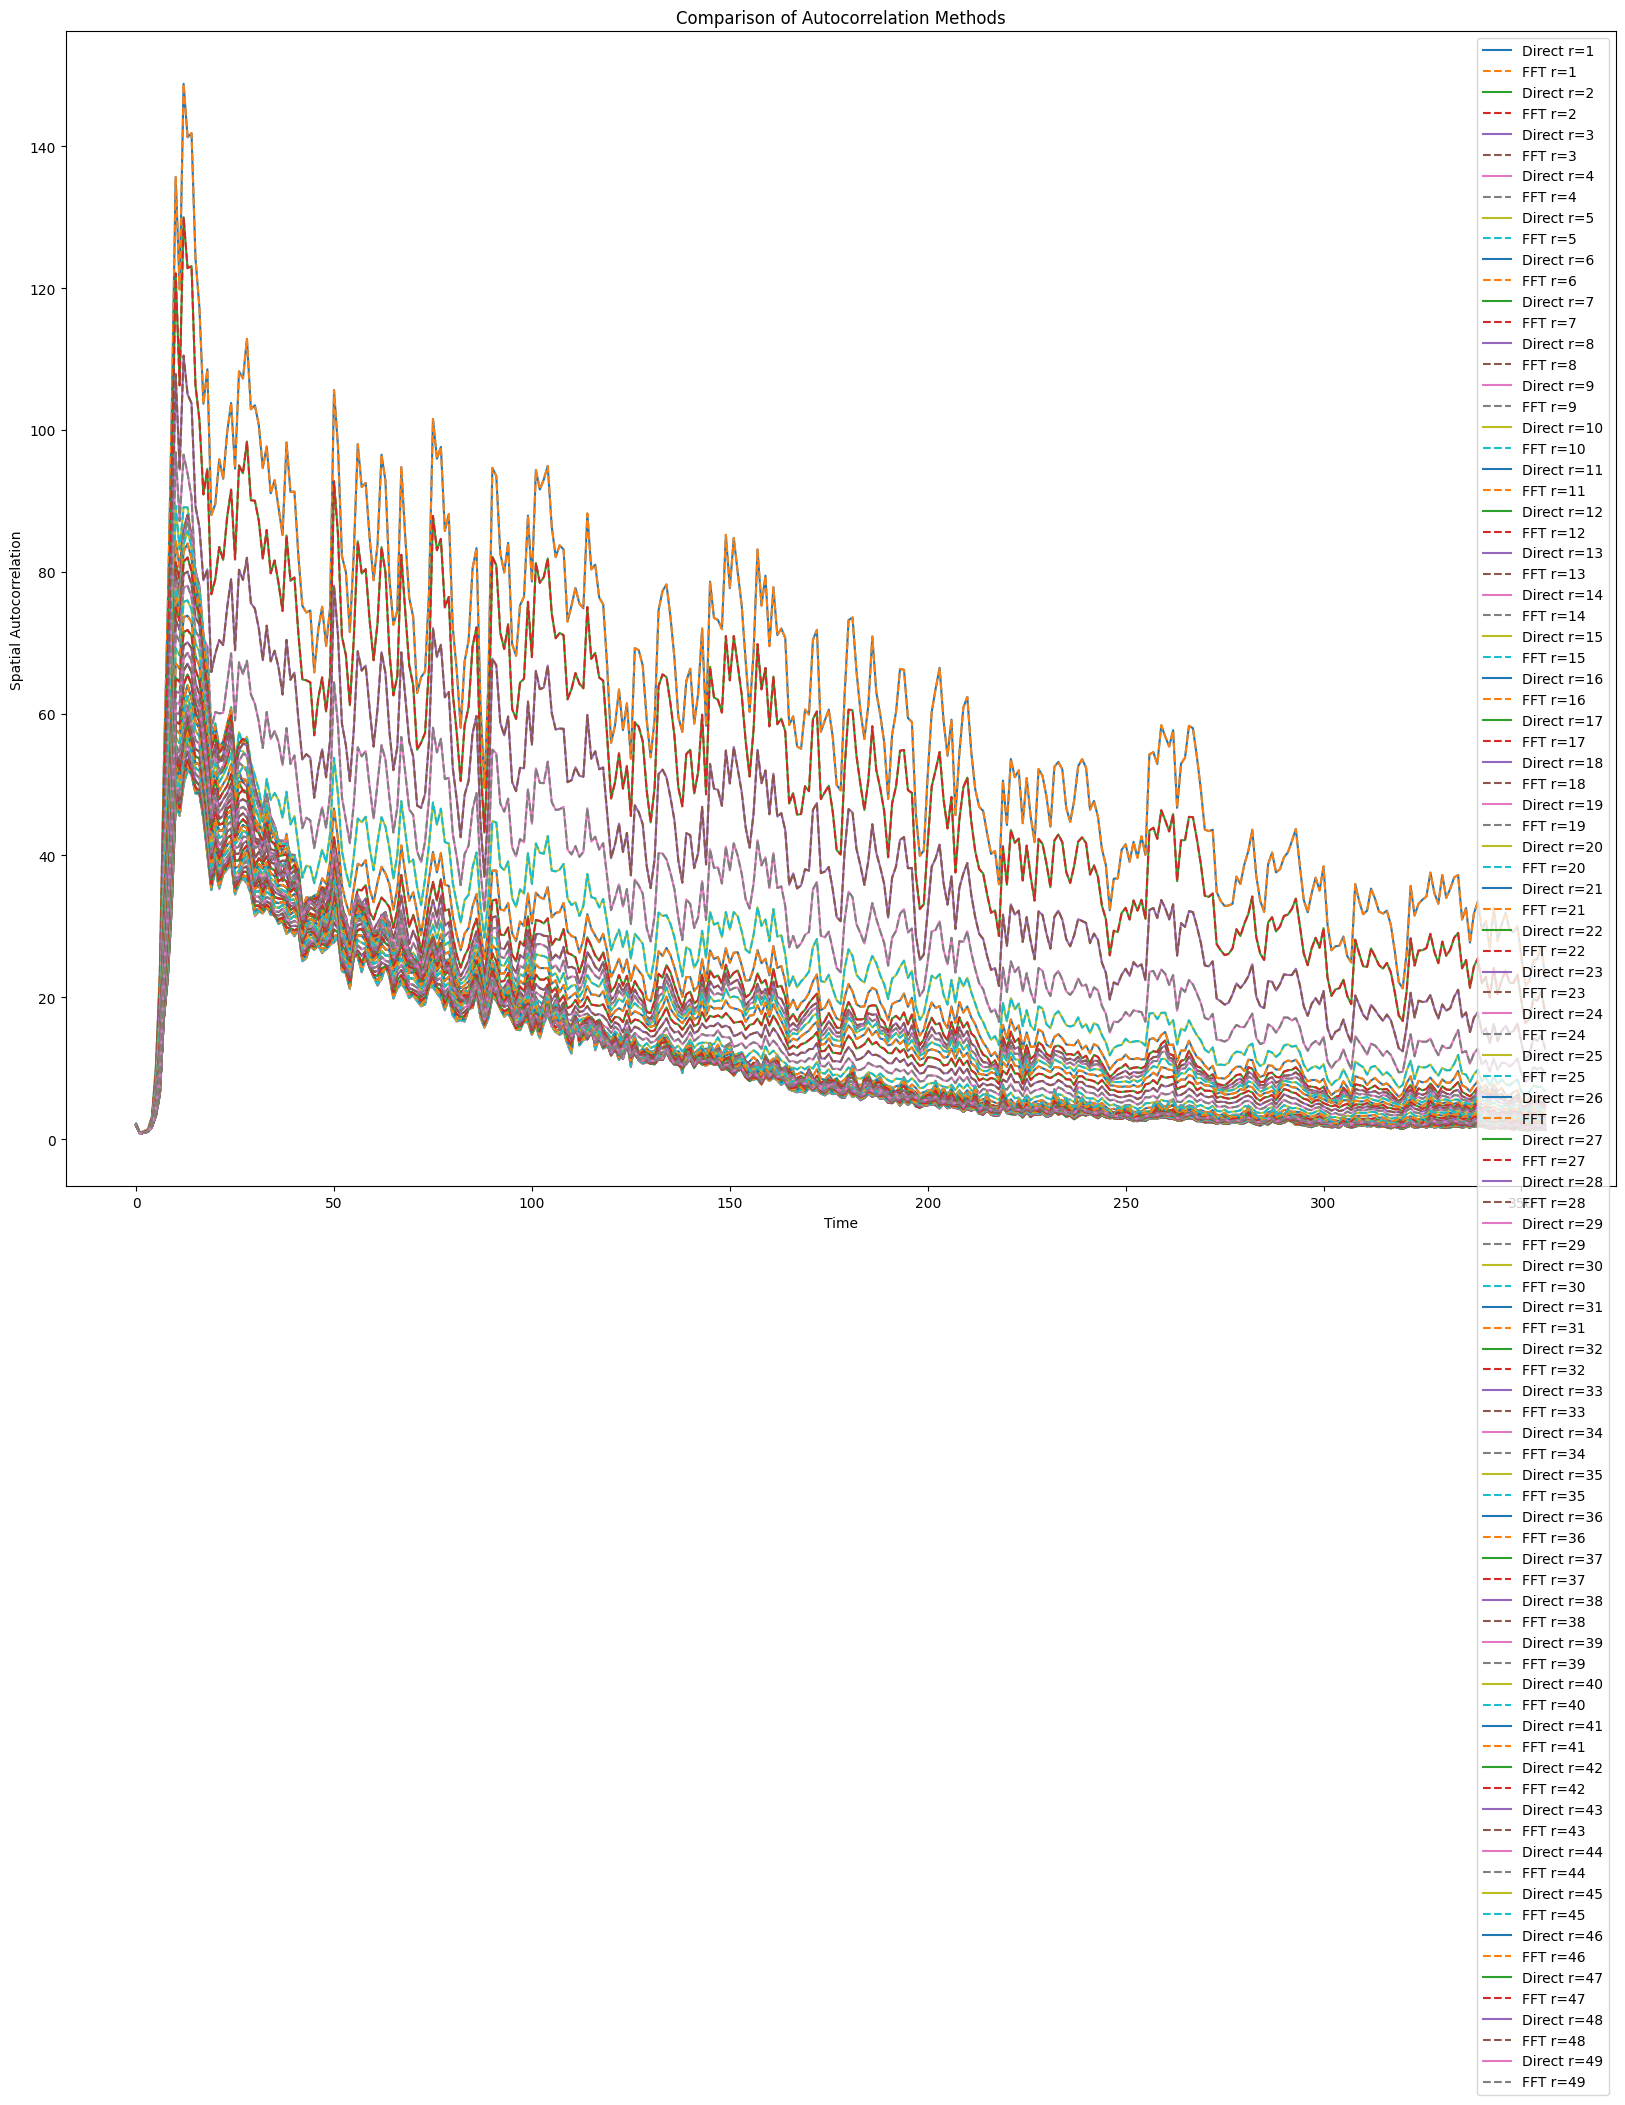

In [3]:


# Load the velocity data
file_path = '/home/shichenliu/Dropbox/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/correlation_good/130_MT_correlation_45_1ul_new/velocity_data.pkl'
with open(file_path, 'rb') as f:
    velocity_data = pickle.load(f)

# Calculate spatial autocorrelation using both methods
direct_results_parallel = compute_autocorrelation_parallel(velocity_data)

# For the purpose of this code, I'm using the same result for FFT-based results
# You'd replace this with the actual FFT method results if you intend to compare both
fft_results = direct_results_parallel  

# Plotting results
plt.figure(figsize=(20, 15))  # Adjusting the figure size: (width, height) in inches
r_values = list(range(1, 50))
for r in r_values:
    plt.plot([direct_results_parallel[tt][r-1] for tt in sorted(direct_results_parallel.keys())], label=f"Direct r={r}")
    plt.plot([fft_results[tt][r-1] for tt in sorted(fft_results.keys())], '--', label=f"FFT r={r}")

plt.legend()
plt.xlabel('Time')
plt.ylabel('Spatial Autocorrelation')
plt.title('Comparison of Autocorrelation Methods')
plt.show()


In [4]:
def get_all_pkl_files(base_dir):
    pkl_files = []
    for root, dirs, files in os.walk(base_dir):
        if "_new" in root:
            for file in files:
                if file.endswith(".pkl"):
                    pkl_files.append(os.path.join(root, file))
    return pkl_files

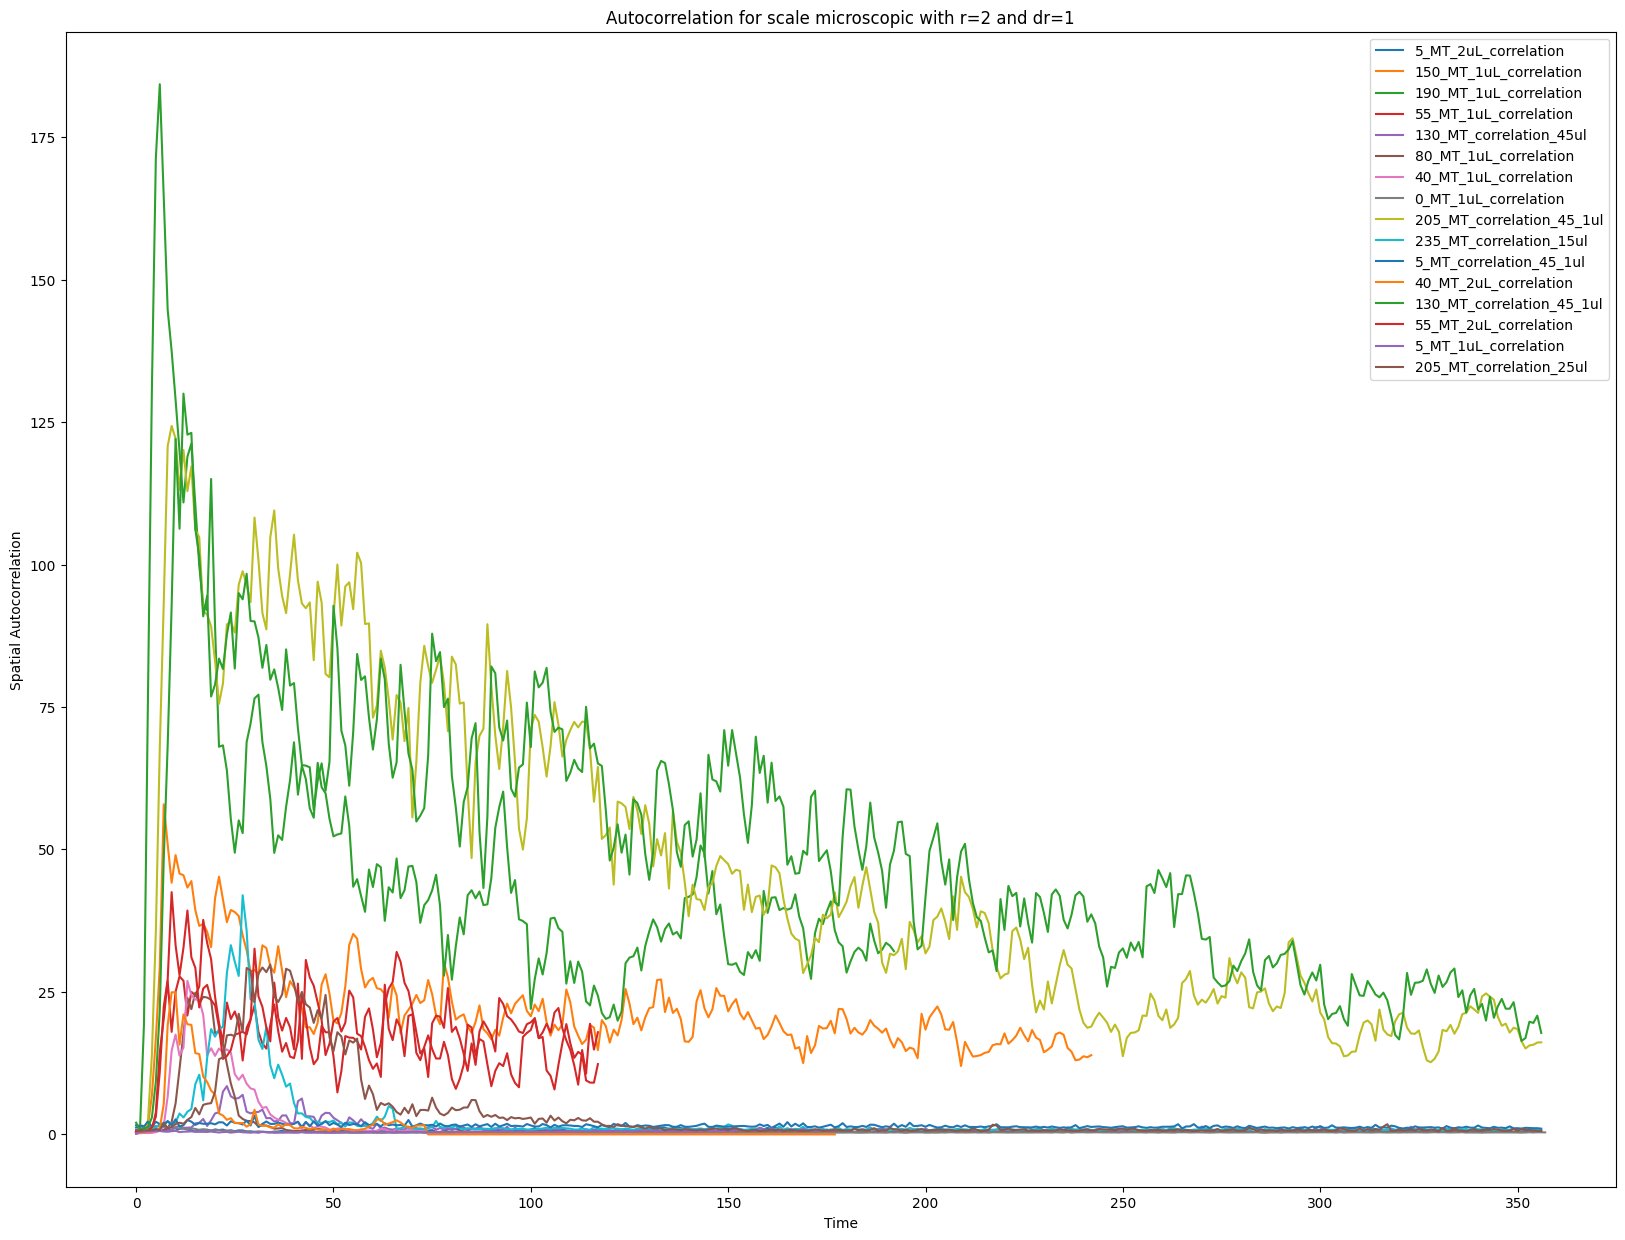

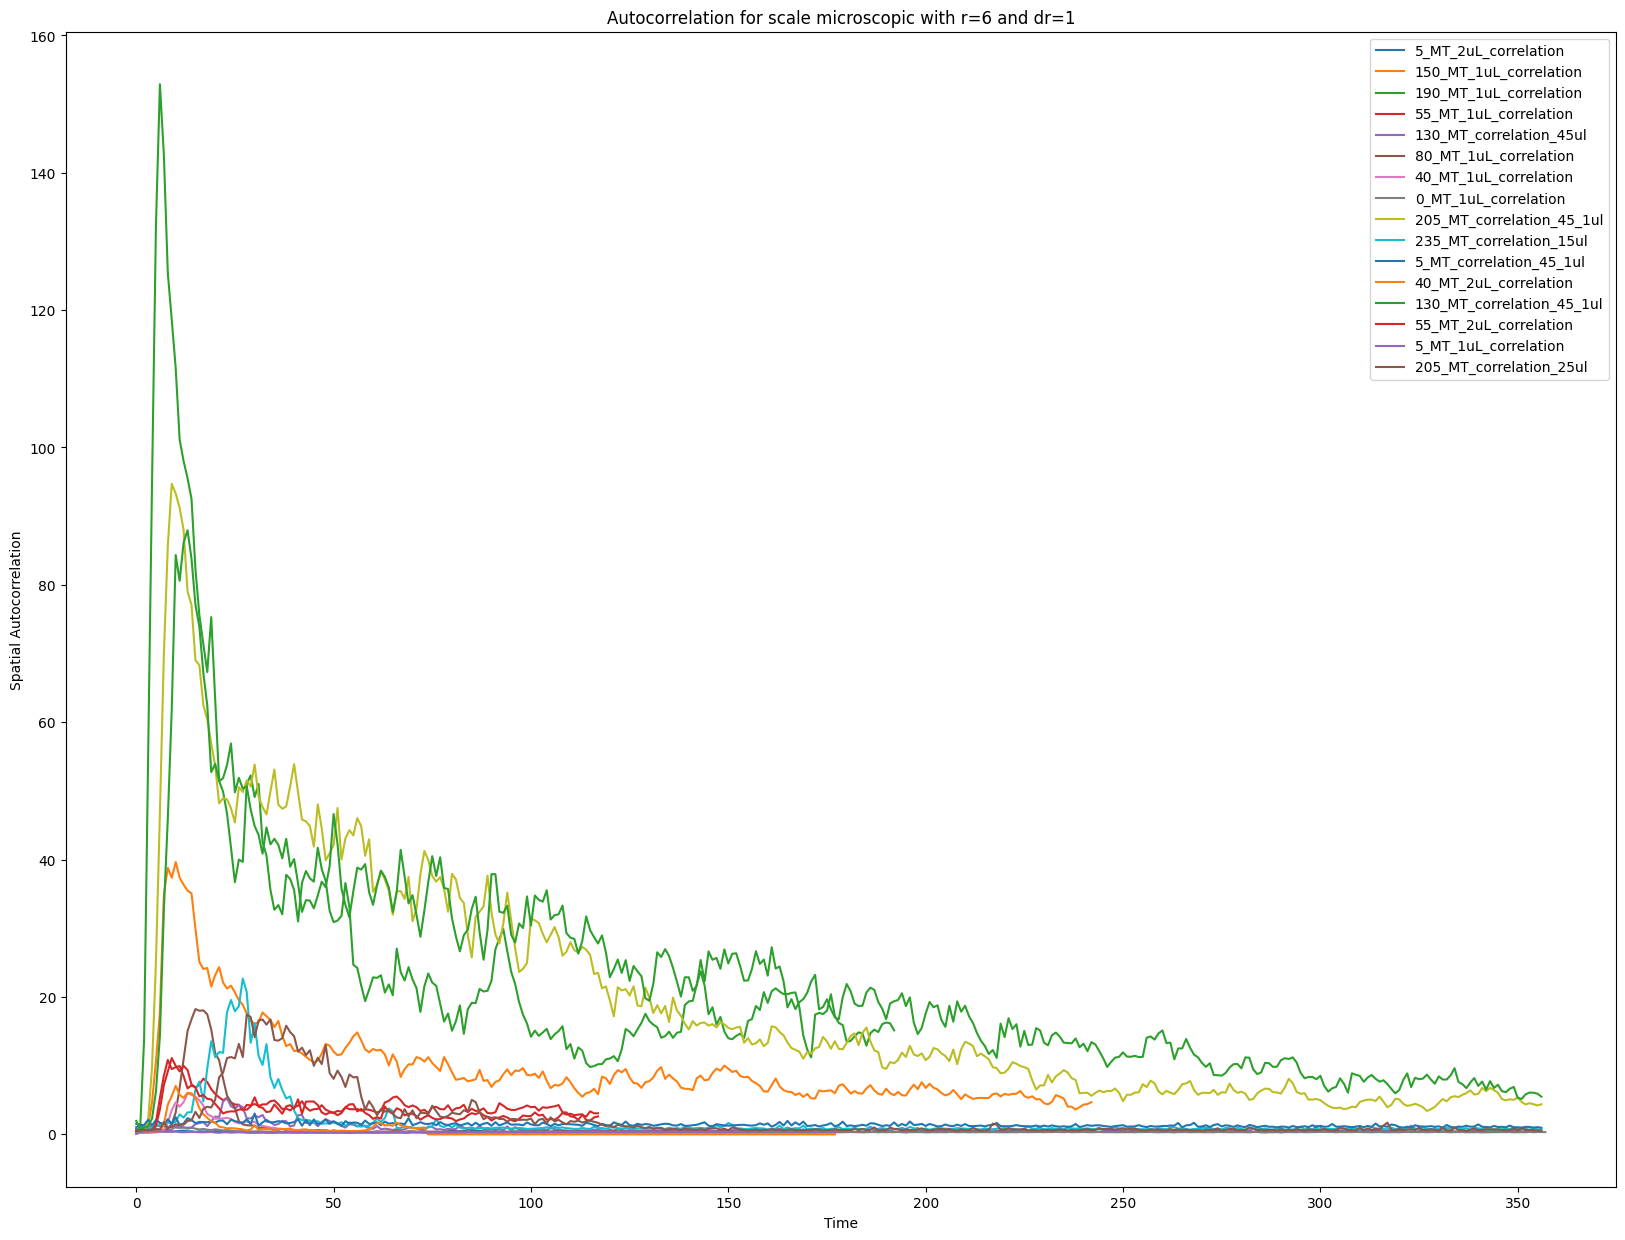

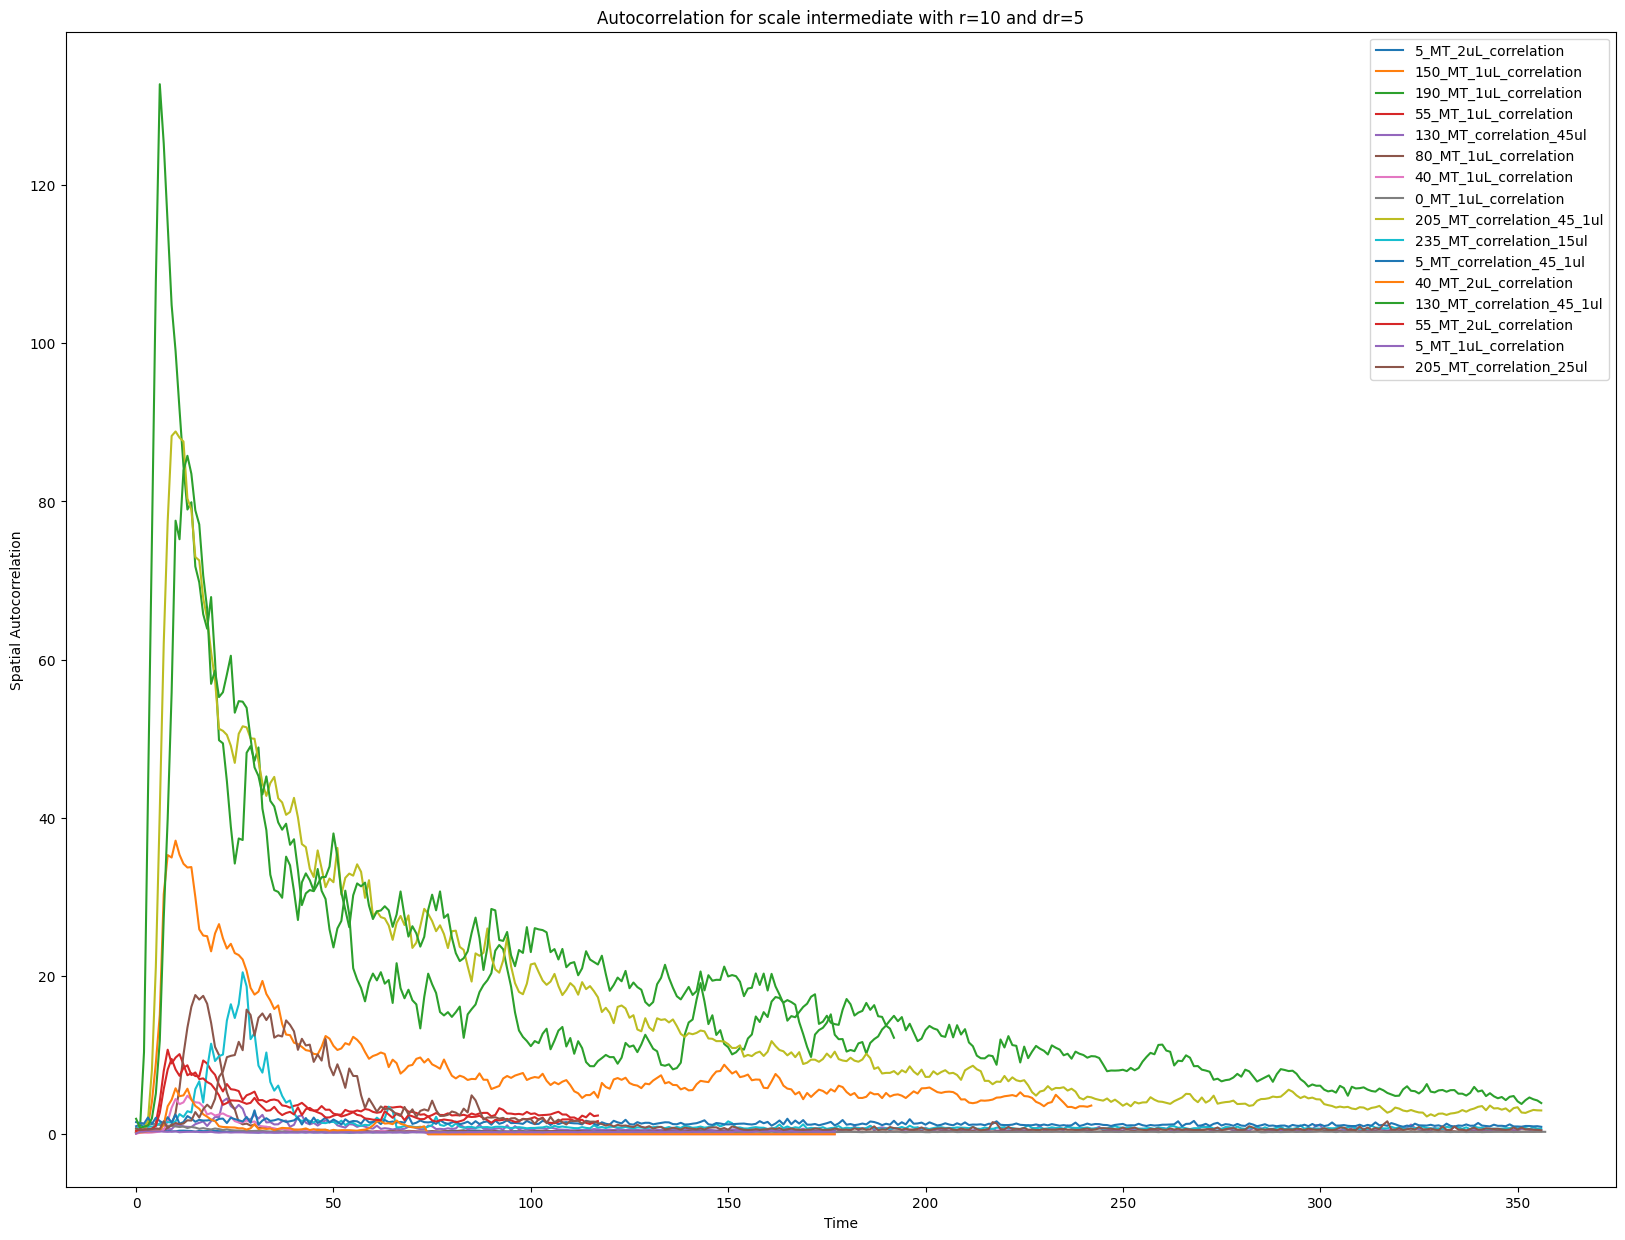

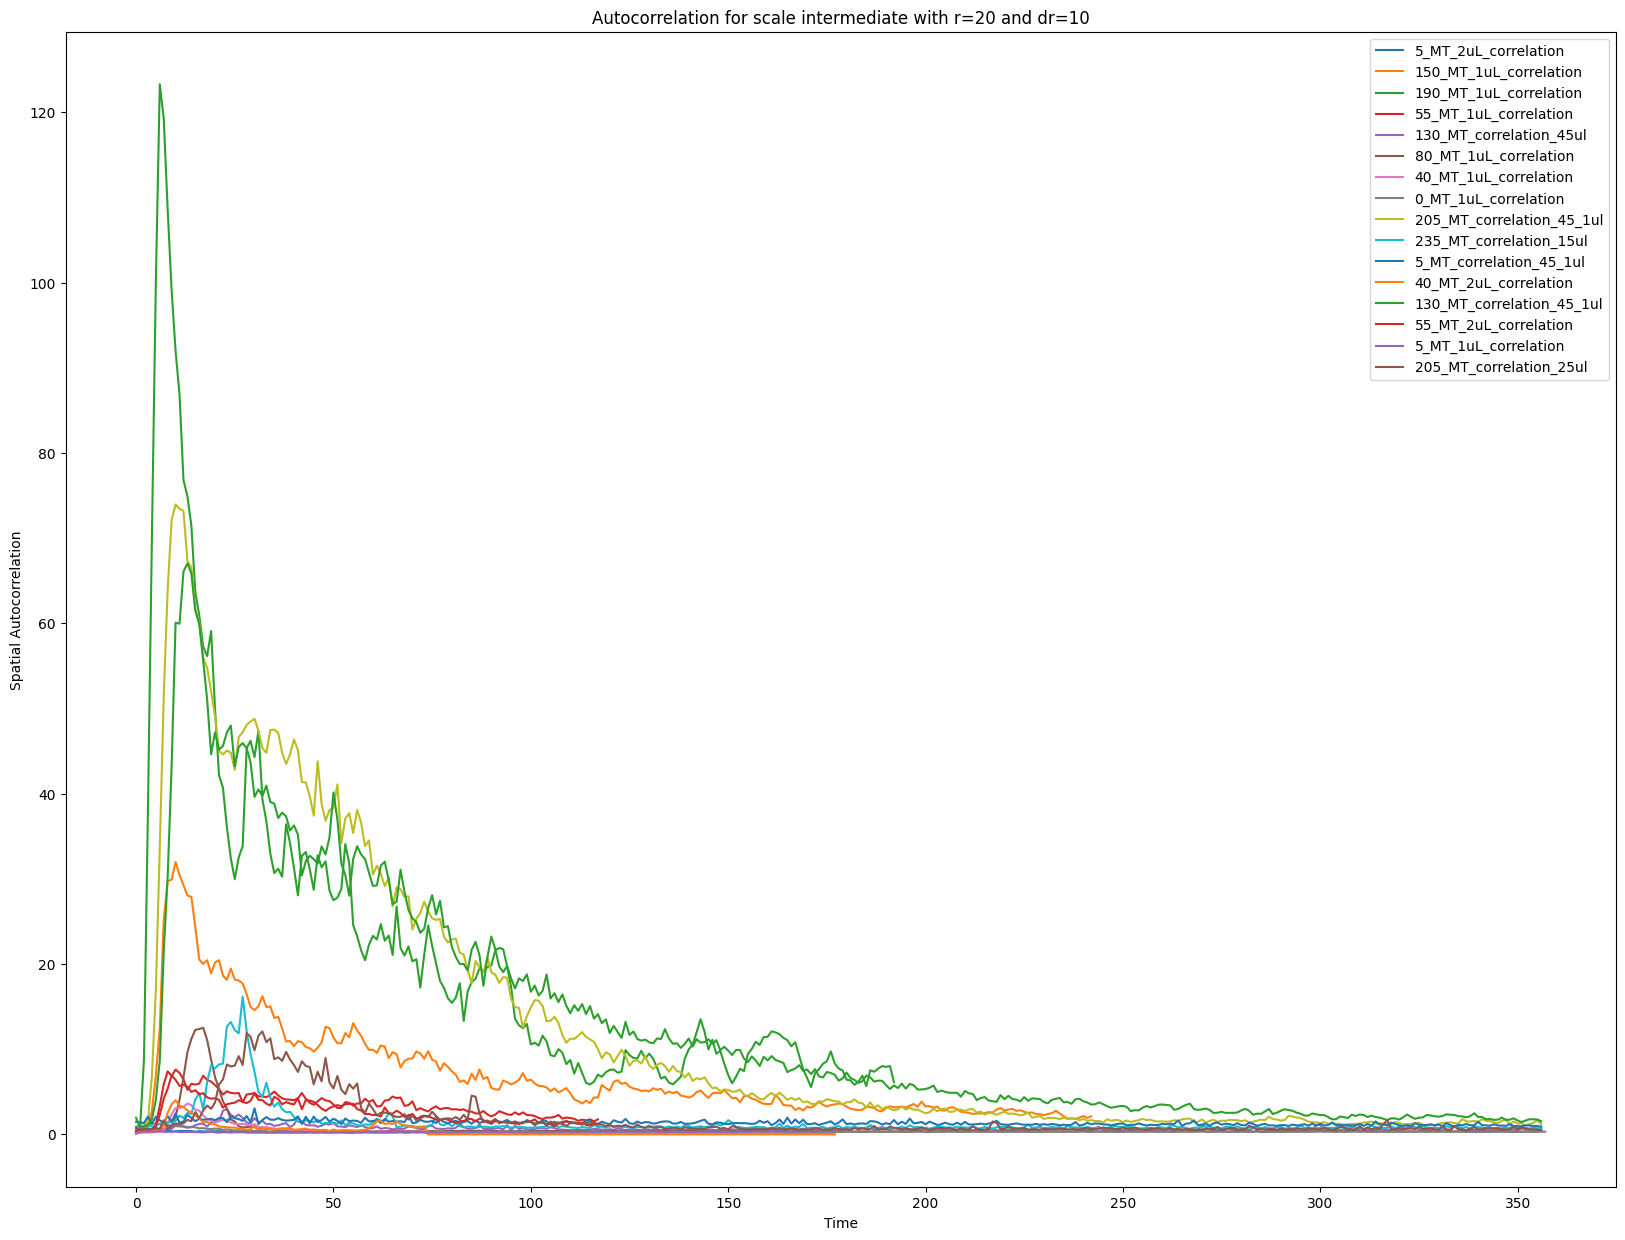

In [5]:


base_directory = "/home/shichenliu/Dropbox/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/correlation_good"
all_pkl_files = get_all_pkl_files(base_directory)

# Define different scales and increments for r
scales = {
    "microscopic": [(2, 1), (6, 1)],
    "intermediate": [(10, 5), (20, 10)]
}

for scale_name, r_dr_values in scales.items():
    for r, dr in r_dr_values:
        
        plt.figure(figsize=(20, 15))  # Create a large plot
        
        for pkl_file in all_pkl_files:
            
            # Load data
            with open(pkl_file, 'rb') as f:
                velocity_data = pickle.load(f)
            
            # Compute autocorrelation
            results_parallel = compute_autocorrelation_parallel(velocity_data)
            
            # Plot
            r_values = list(range(1, 50))
            folder_name = os.path.basename(os.path.dirname(pkl_file)).replace("_new", "")
            plt.plot([results_parallel[tt][r-1] if r-1 < len(results_parallel[tt]) else np.nan for tt in sorted(results_parallel.keys())], label=folder_name)
        
        plt.legend()
        plt.xlabel('Time')
        plt.ylabel('Spatial Autocorrelation')
        plt.title(f'Autocorrelation for scale {scale_name} with r={r} and dr={dr}')
        plt.show()



# Clipped data

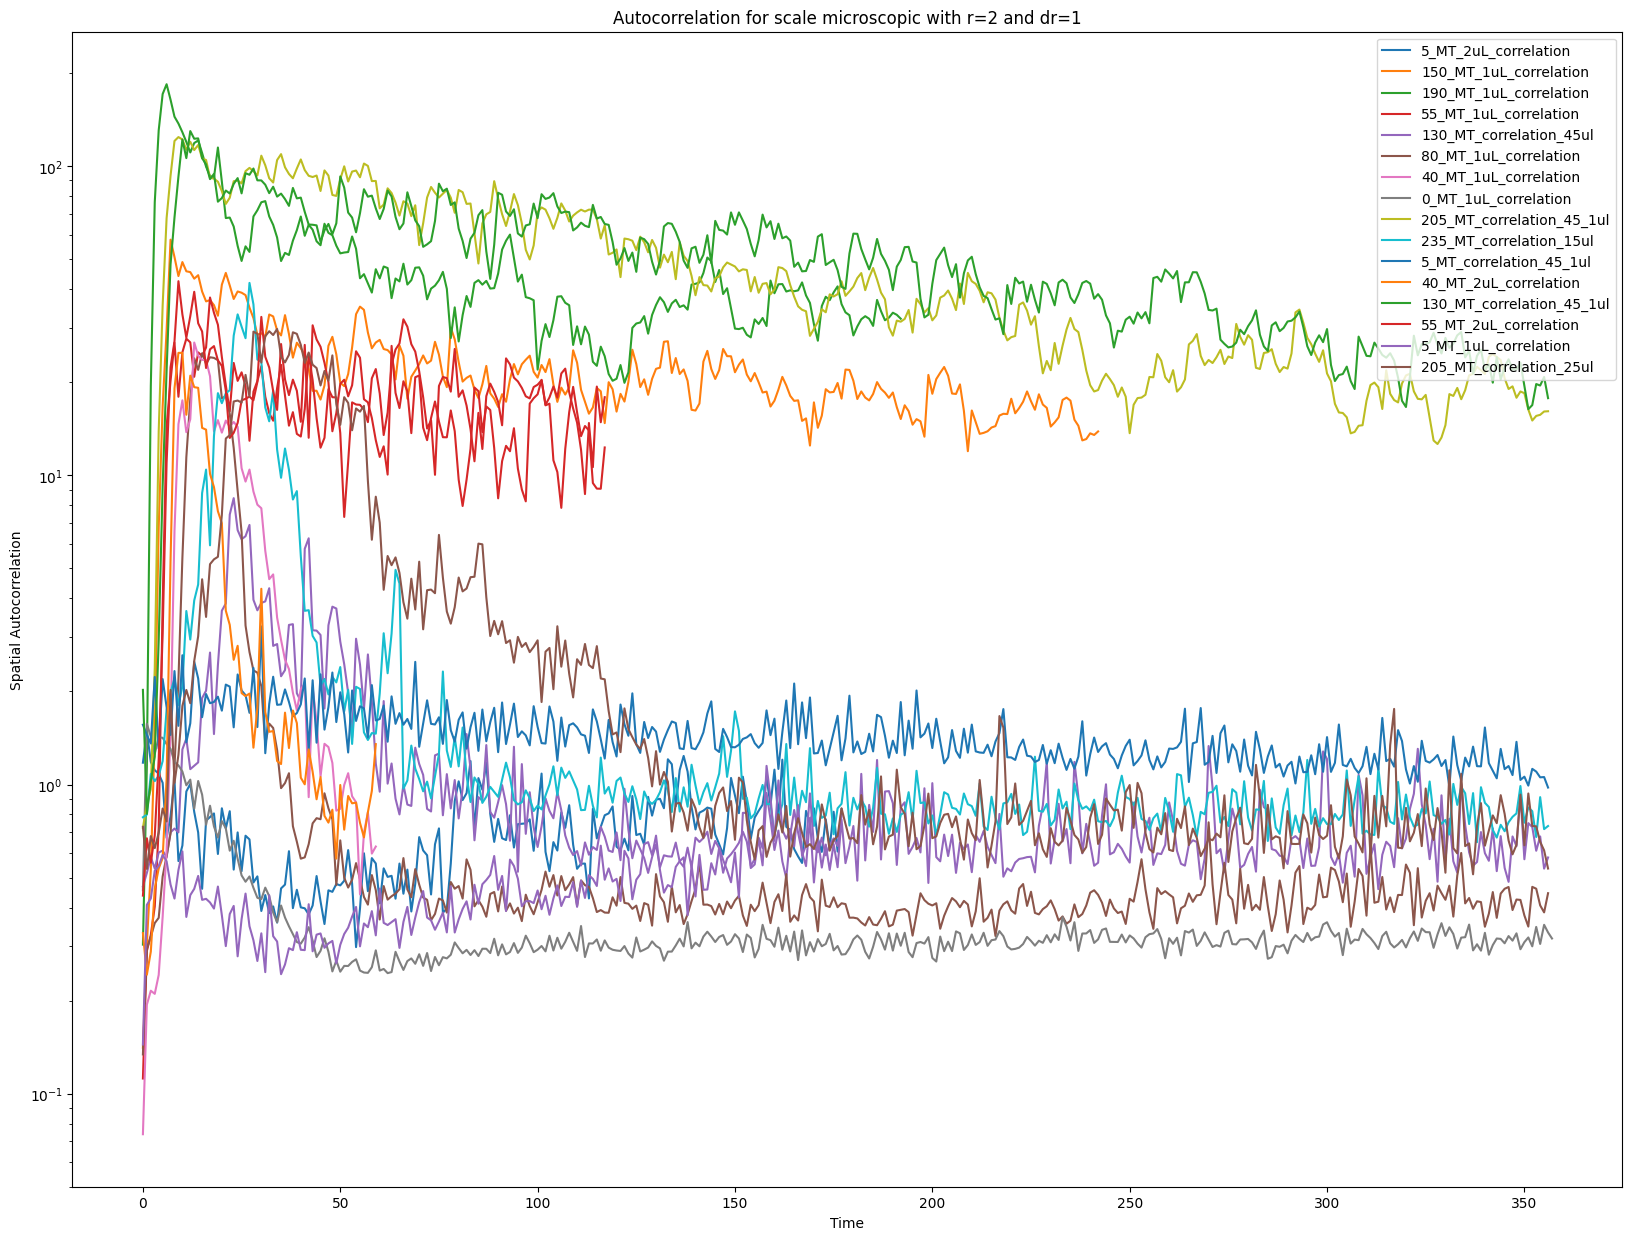

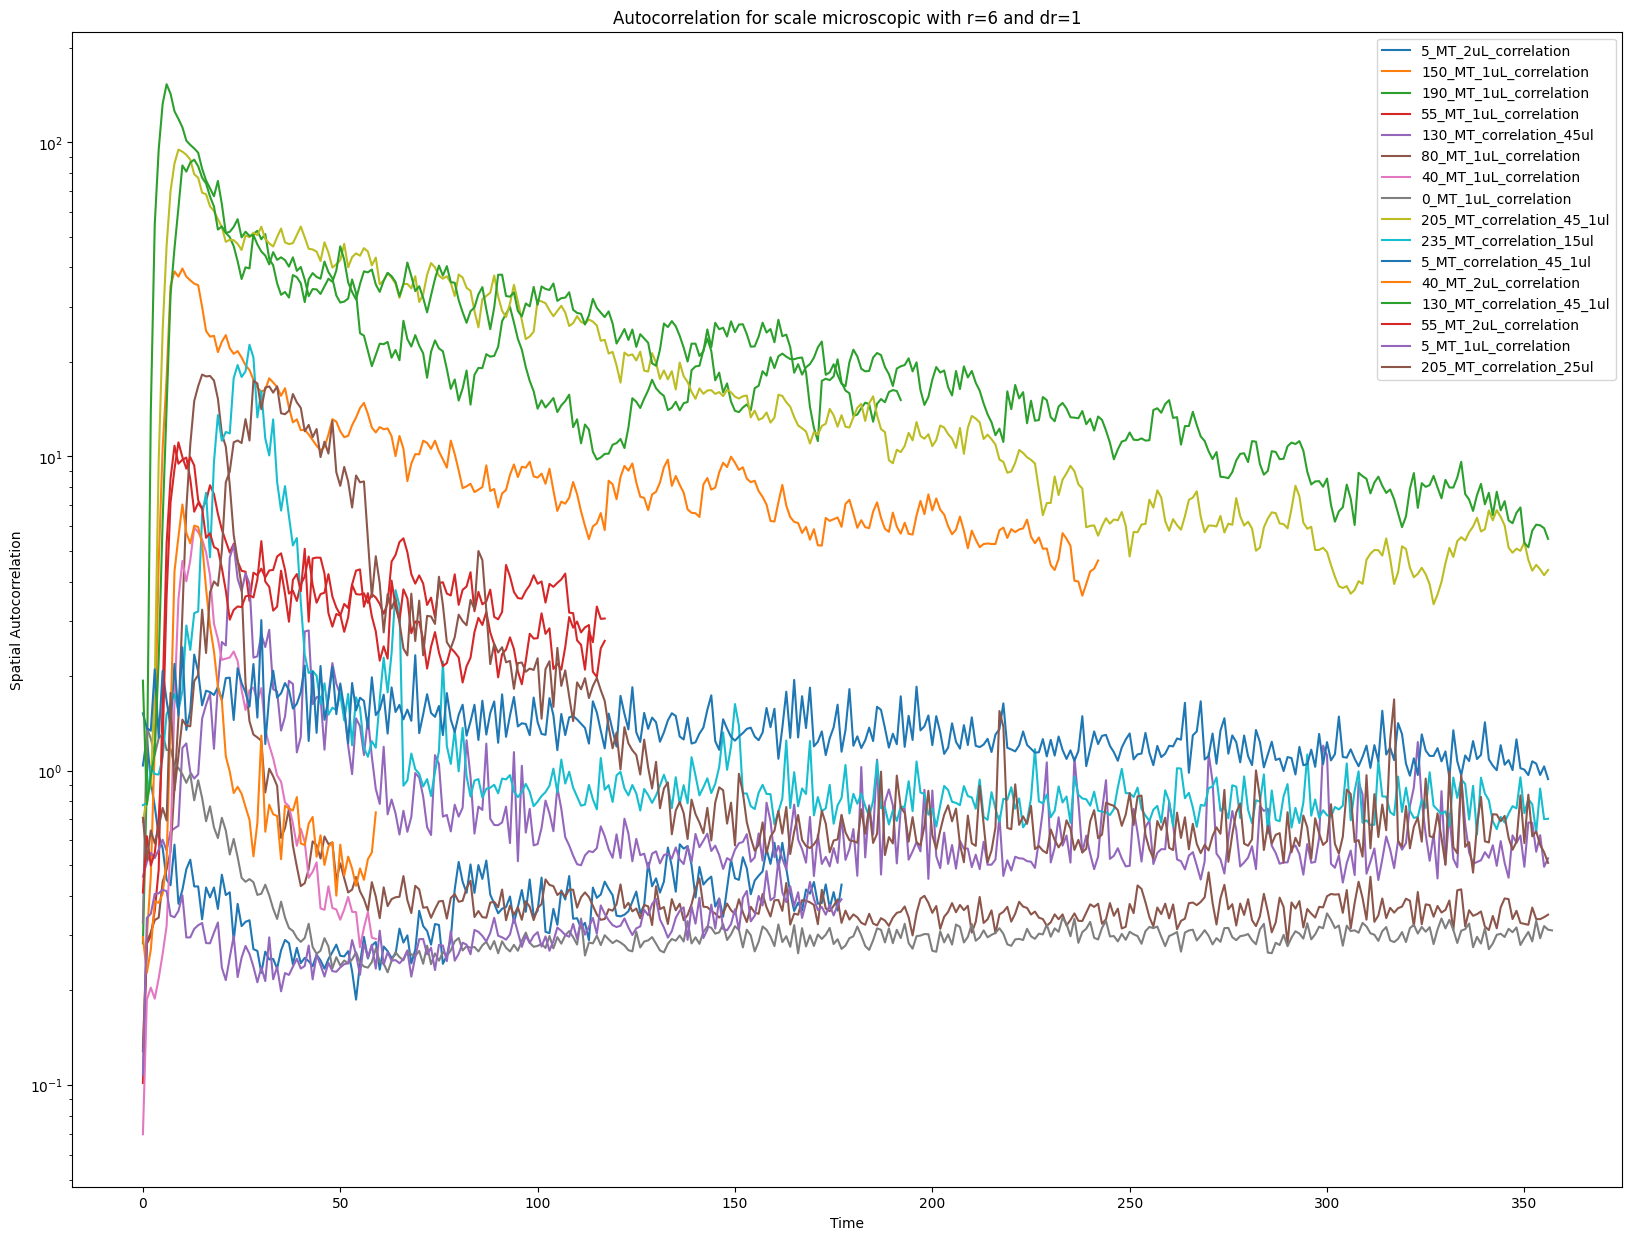

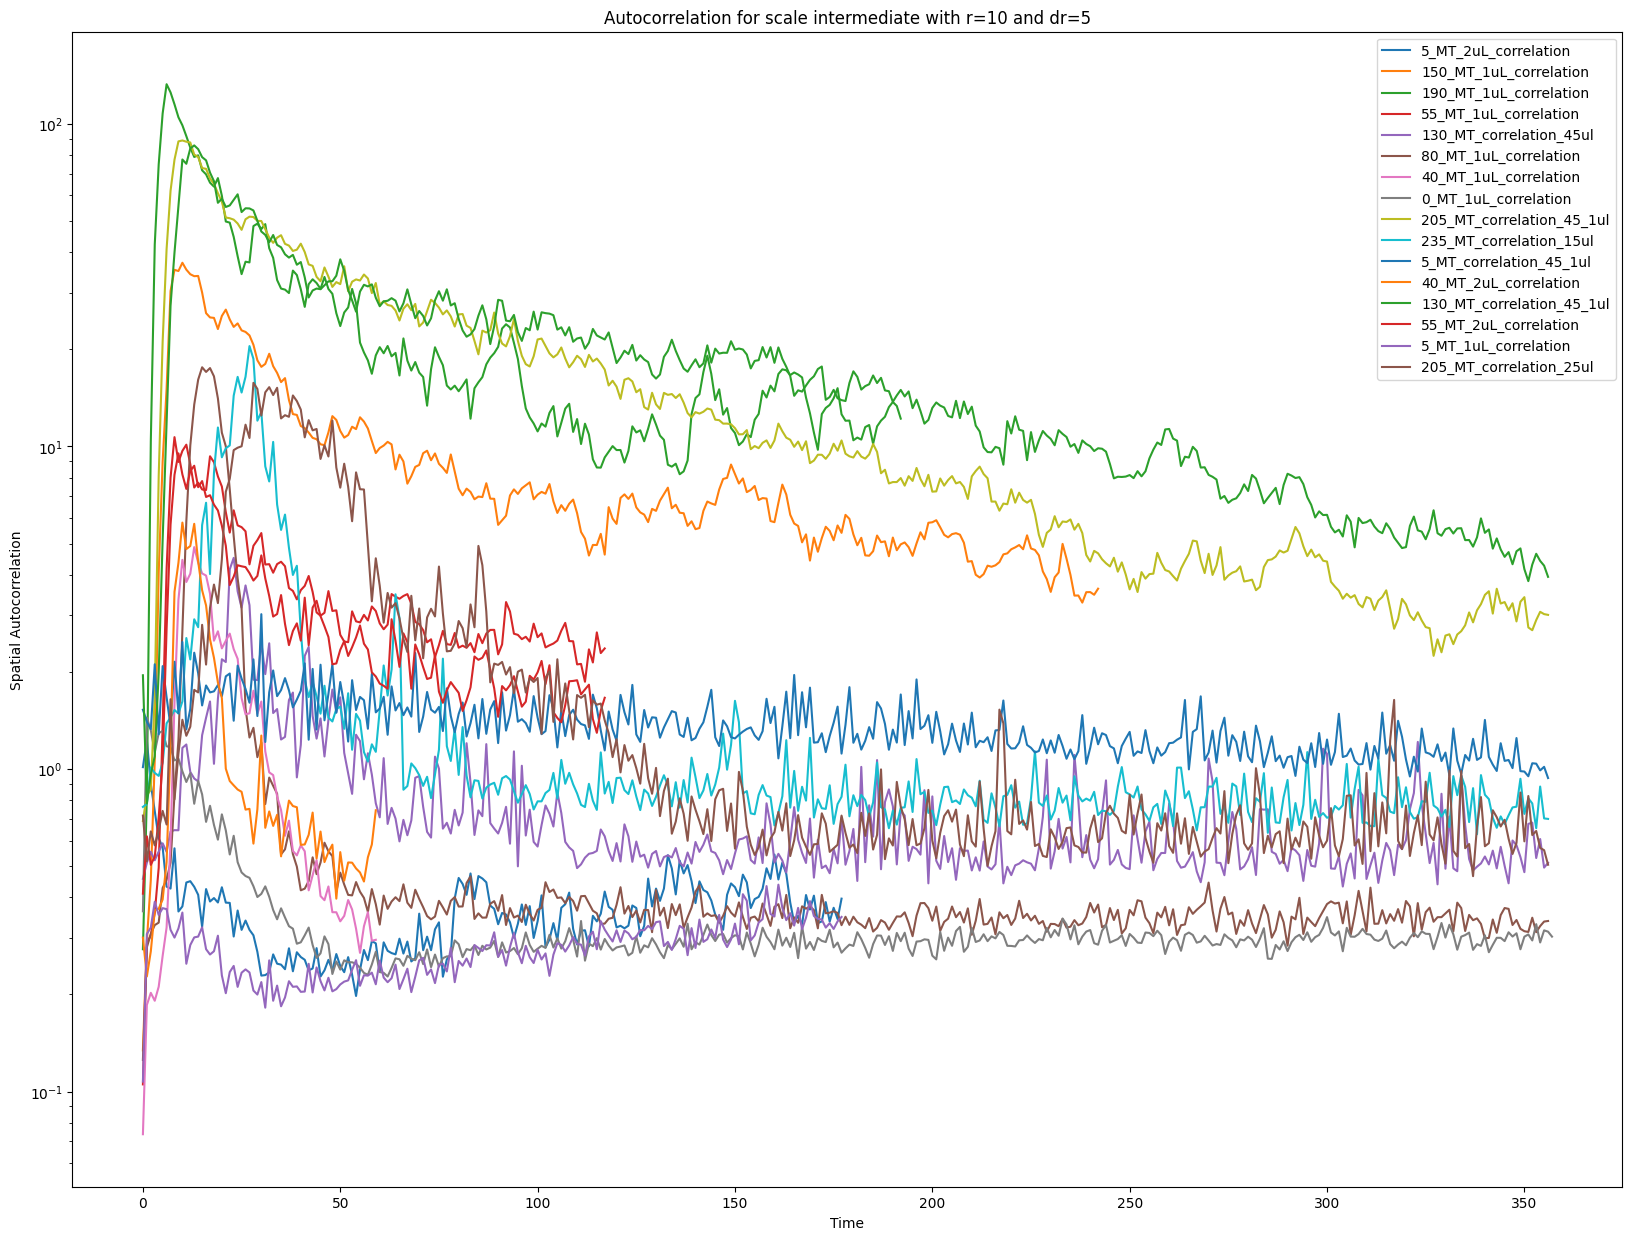

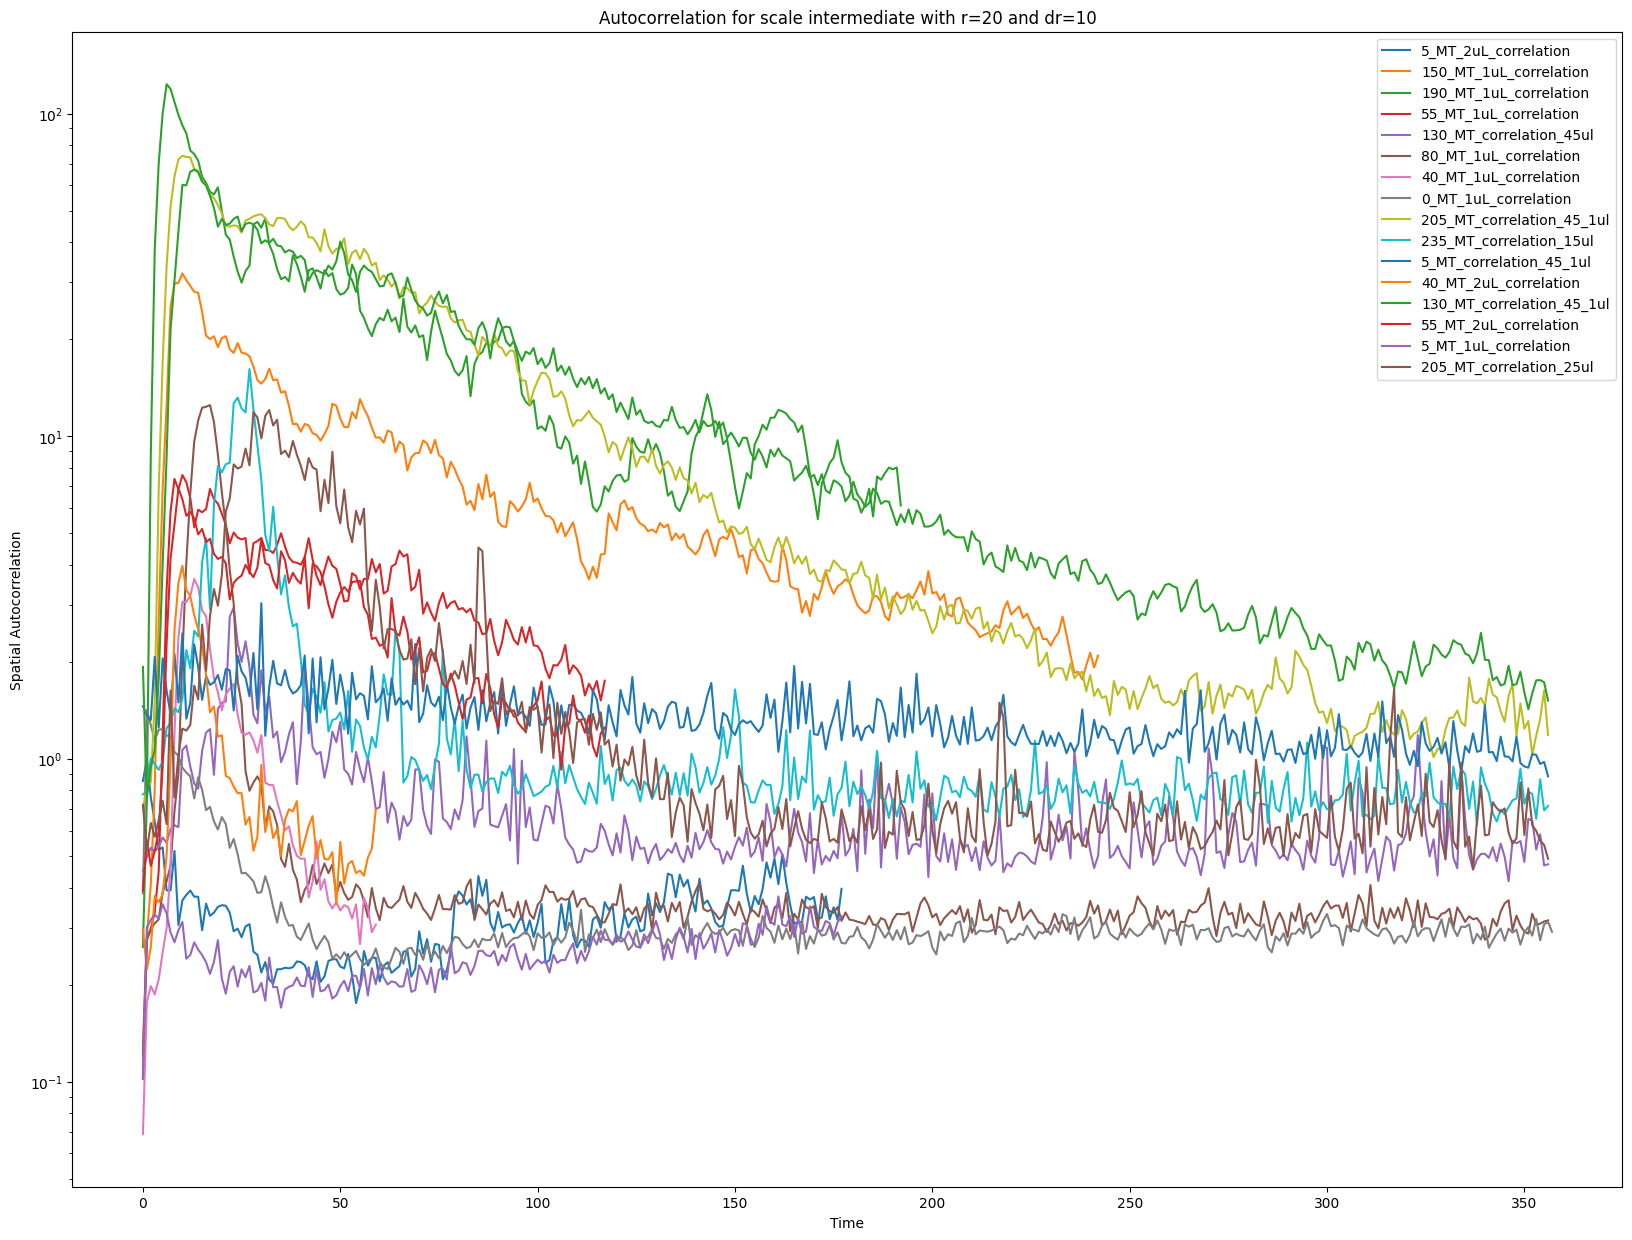

In [6]:
base_directory = "/home/shichenliu/Dropbox/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/correlation_good"
all_pkl_files = get_all_pkl_files(base_directory)

# Define different scales and increments for r
scales = {
    "microscopic": [(2, 1), (6, 1)],
    "intermediate": [(10, 5), (20, 10)]
}

for scale_name, r_dr_values in scales.items():
    for r, dr in r_dr_values:
        
        plt.figure(figsize=(20, 15))  # Create a large plot
        
        for pkl_file in all_pkl_files:
            
            # Load data
            with open(pkl_file, 'rb') as f:
                velocity_data = pickle.load(f)
            
            folder_name = os.path.basename(os.path.dirname(pkl_file)).replace("_new", "")
            
            # If the folder is 40_MT_2uL_correlation, clip after 60 frames
            if folder_name == "40_MT_2uL_correlation":
                velocity_data = {k: v for k, v in velocity_data.items() if k < 60}
            if folder_name == "40_MT_1uL_correlation":
                velocity_data = {k: v for k, v in velocity_data.items() if k < 60}
            
            # Compute autocorrelation
            results_parallel = compute_autocorrelation_parallel(velocity_data)
            
            # Clip data below 10^-2
            data_to_plot = [max(1e-2, results_parallel[tt][r-1]) if r-1 < len(results_parallel[tt]) else np.nan for tt in sorted(results_parallel.keys())]
            
            plt.plot(data_to_plot, label=folder_name)
        
        plt.legend()
        plt.yscale("log")
        plt.xlabel('Time')
        plt.ylabel('Spatial Autocorrelation')
        plt.title(f'Autocorrelation for scale {scale_name} with r={r} and dr={dr}')
        plt.show()


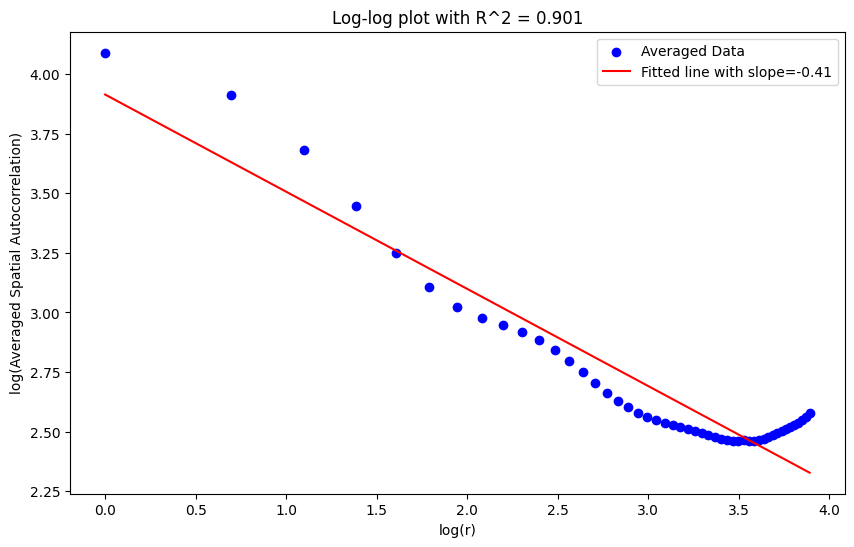

In [7]:
# Averaging the spatial autocorrelation values over all time points
averaged_autocorrelation = [np.mean([direct_results_parallel[tt][r-1] for tt in sorted(direct_results_parallel.keys())]) for r in r_values]

# Plot the averaged values on a log-log scale
log_r = np.log(r_values)
log_averaged_autocorrelation = np.log(averaged_autocorrelation)
plt.figure(figsize=(10, 6))
plt.scatter(log_r, log_averaged_autocorrelation, c='blue', label='Averaged Data')

# Perform linear regression on the log-transformed values
slope, intercept, r_value, _, _ = linregress(log_r, log_averaged_autocorrelation)
plt.plot(log_r, intercept + slope*log_r, 'r', label=f'Fitted line with slope={slope:.2f}')
plt.title(f'Log-log plot with R^2 = {r_value**2:.3f}')
plt.xlabel('log(r)')
plt.ylabel('log(Averaged Spatial Autocorrelation)')
plt.legend()
plt.show()


In [8]:
# velocity correlation

def compute_vorticity(UX, UY):
    dVY_dx = np.gradient(UY, axis=1)
    dUX_dy = np.gradient(UX, axis=0)
    return dVY_dx - dUX_dy

def mean_subtracted_velocity_correlation(UX, UY, r):
    mean_UX = np.mean(UX)
    mean_UY = np.mean(UY)
    UX_dev = UX - mean_UX
    UY_dev = UY - mean_UY
    correlation = (UX_dev * np.roll(UX_dev, shift=-r, axis=1)) + (UY_dev * np.roll(UY_dev, shift=-r, axis=0))
    return np.mean(correlation)

def angular_velocity_correlation(omega, r):
    correlation = omega * np.roll(omega, shift=-r, axis=1)
    return np.mean(correlation)




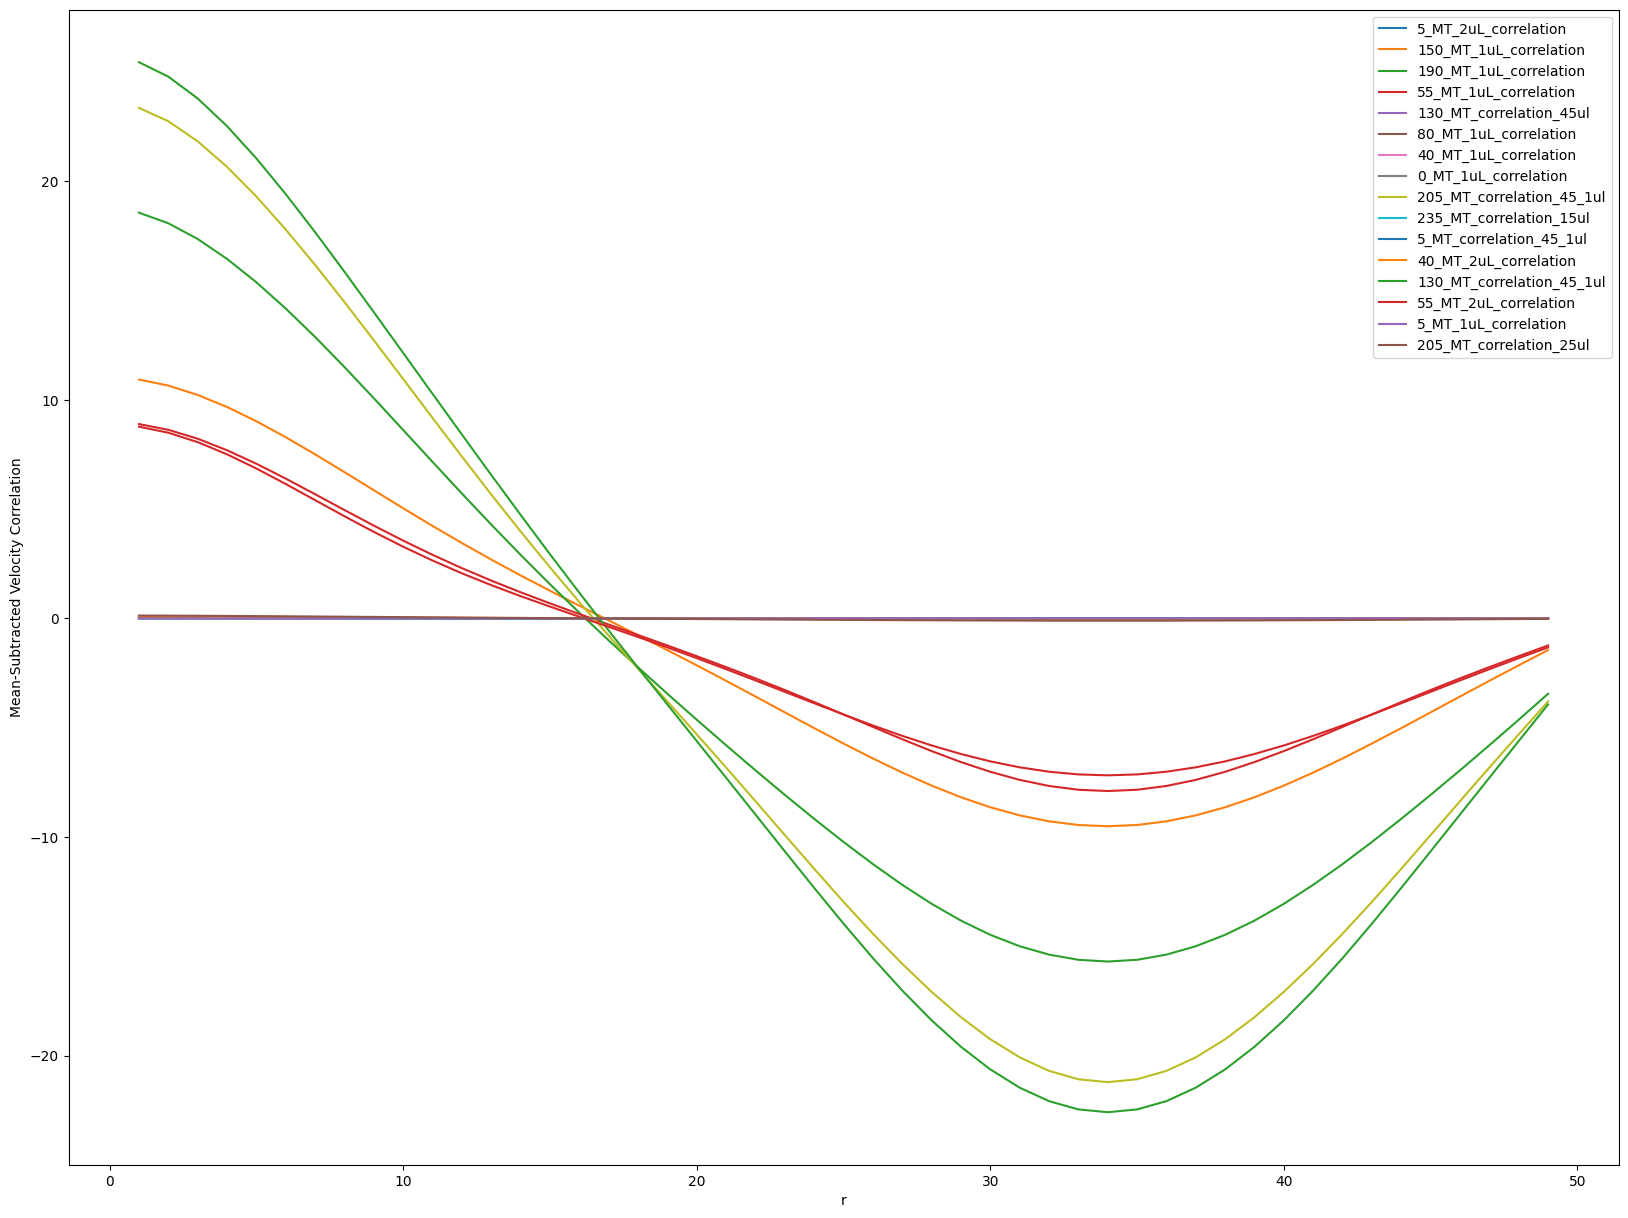

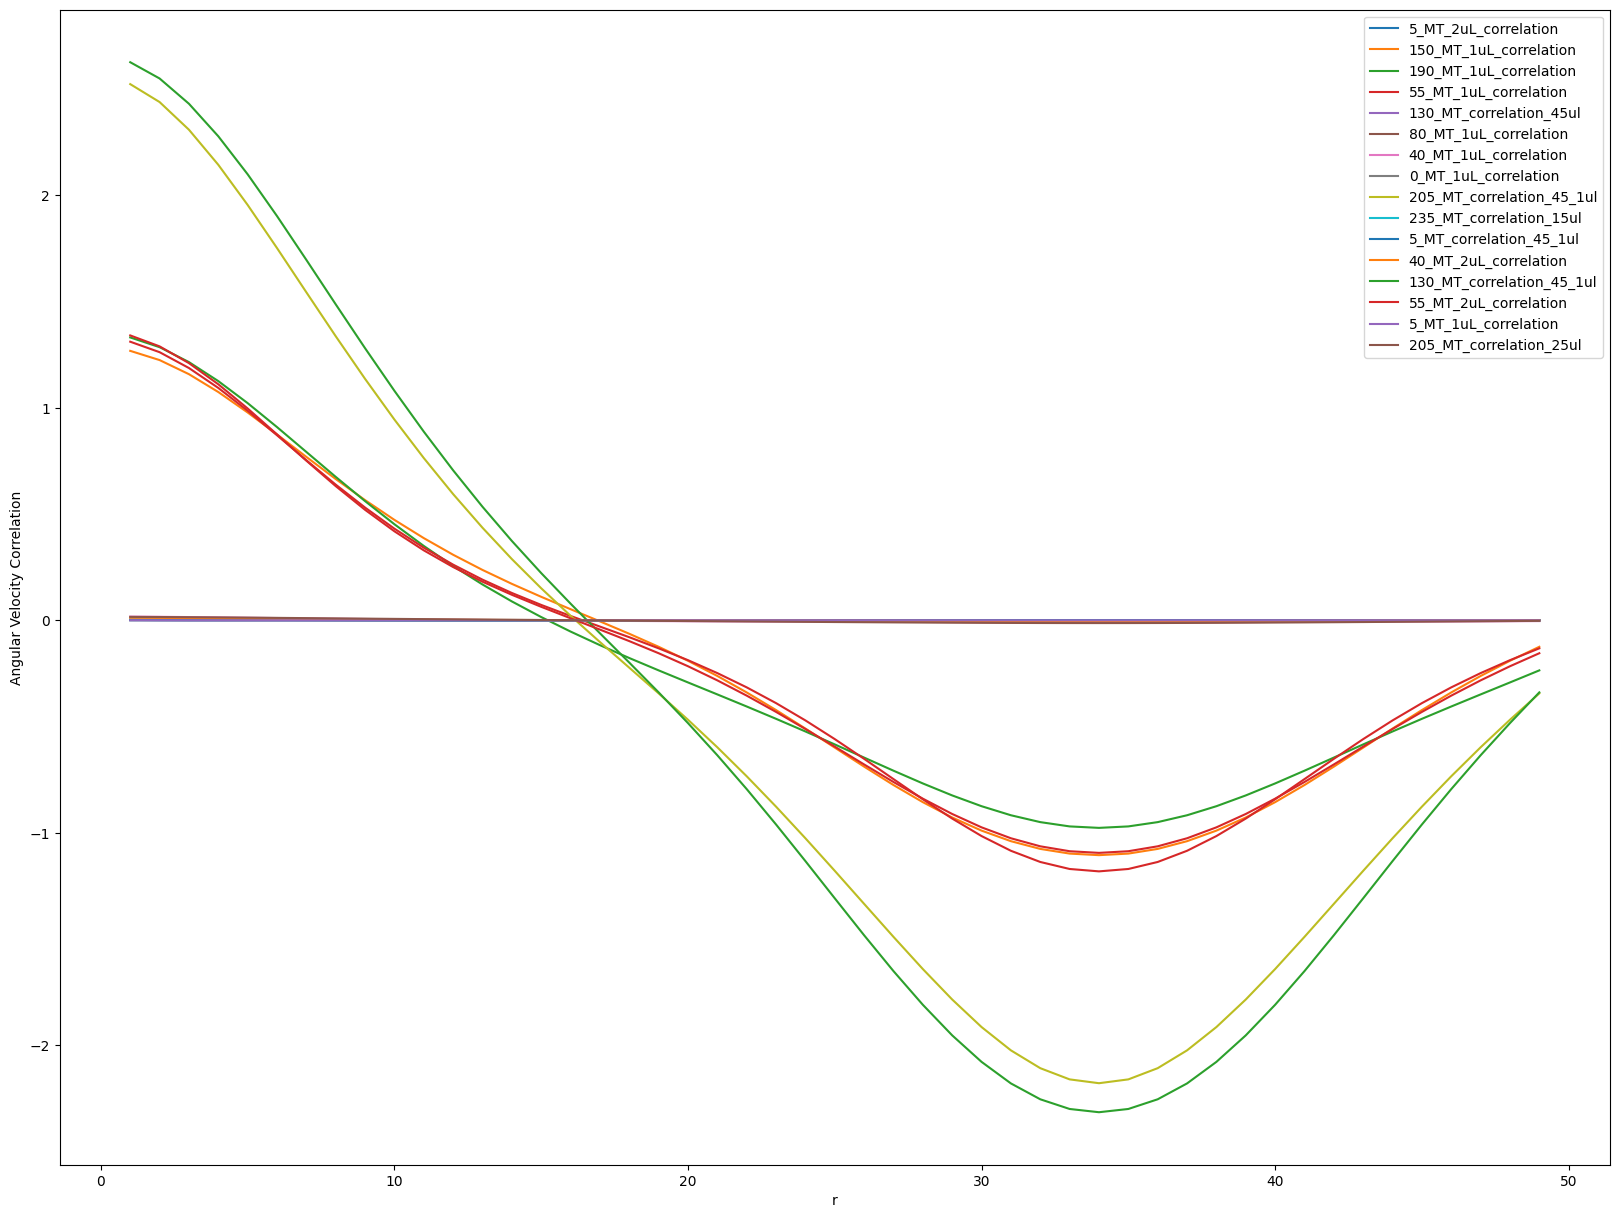

In [9]:
base_directory = "/home/shichenliu/Dropbox/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/correlation_good"
all_pkl_files = get_all_pkl_files(base_directory)

r_values = list(range(1, 50))

# Plotting Mean-Subtracted Velocity Correlation for all experiments
plt.figure(figsize=(20, 15))
for pkl_file in all_pkl_files:
    with open(pkl_file, 'rb') as f:
        velocity_data = pickle.load(f)
    
    avg_UX = np.mean([data[0] for data in velocity_data.values()], axis=0)
    avg_UY = np.mean([data[1] for data in velocity_data.values()], axis=0)

    mean_subtracted_vals = [mean_subtracted_velocity_correlation(avg_UX, avg_UY, r) for r in r_values]
    plt.plot(r_values, mean_subtracted_vals, label=os.path.basename(os.path.dirname(pkl_file)).replace("_new", ""))

plt.xlabel('r')
plt.ylabel('Mean-Subtracted Velocity Correlation')
plt.legend()
plt.show()

# Plotting Angular Velocity Correlation for all experiments
plt.figure(figsize=(20, 15))
for pkl_file in all_pkl_files:
    with open(pkl_file, 'rb') as f:
        velocity_data = pickle.load(f)
    
    avg_UX = np.mean([data[0] for data in velocity_data.values()], axis=0)
    avg_UY = np.mean([data[1] for data in velocity_data.values()], axis=0)
    omega = compute_vorticity(avg_UX, avg_UY)

    angular_vals = [angular_velocity_correlation(omega, r) for r in r_values]
    plt.plot(r_values, angular_vals, label=os.path.basename(os.path.dirname(pkl_file)).replace("_new", ""))

plt.xlabel('r')
plt.ylabel('Angular Velocity Correlation')
plt.legend()
plt.show()

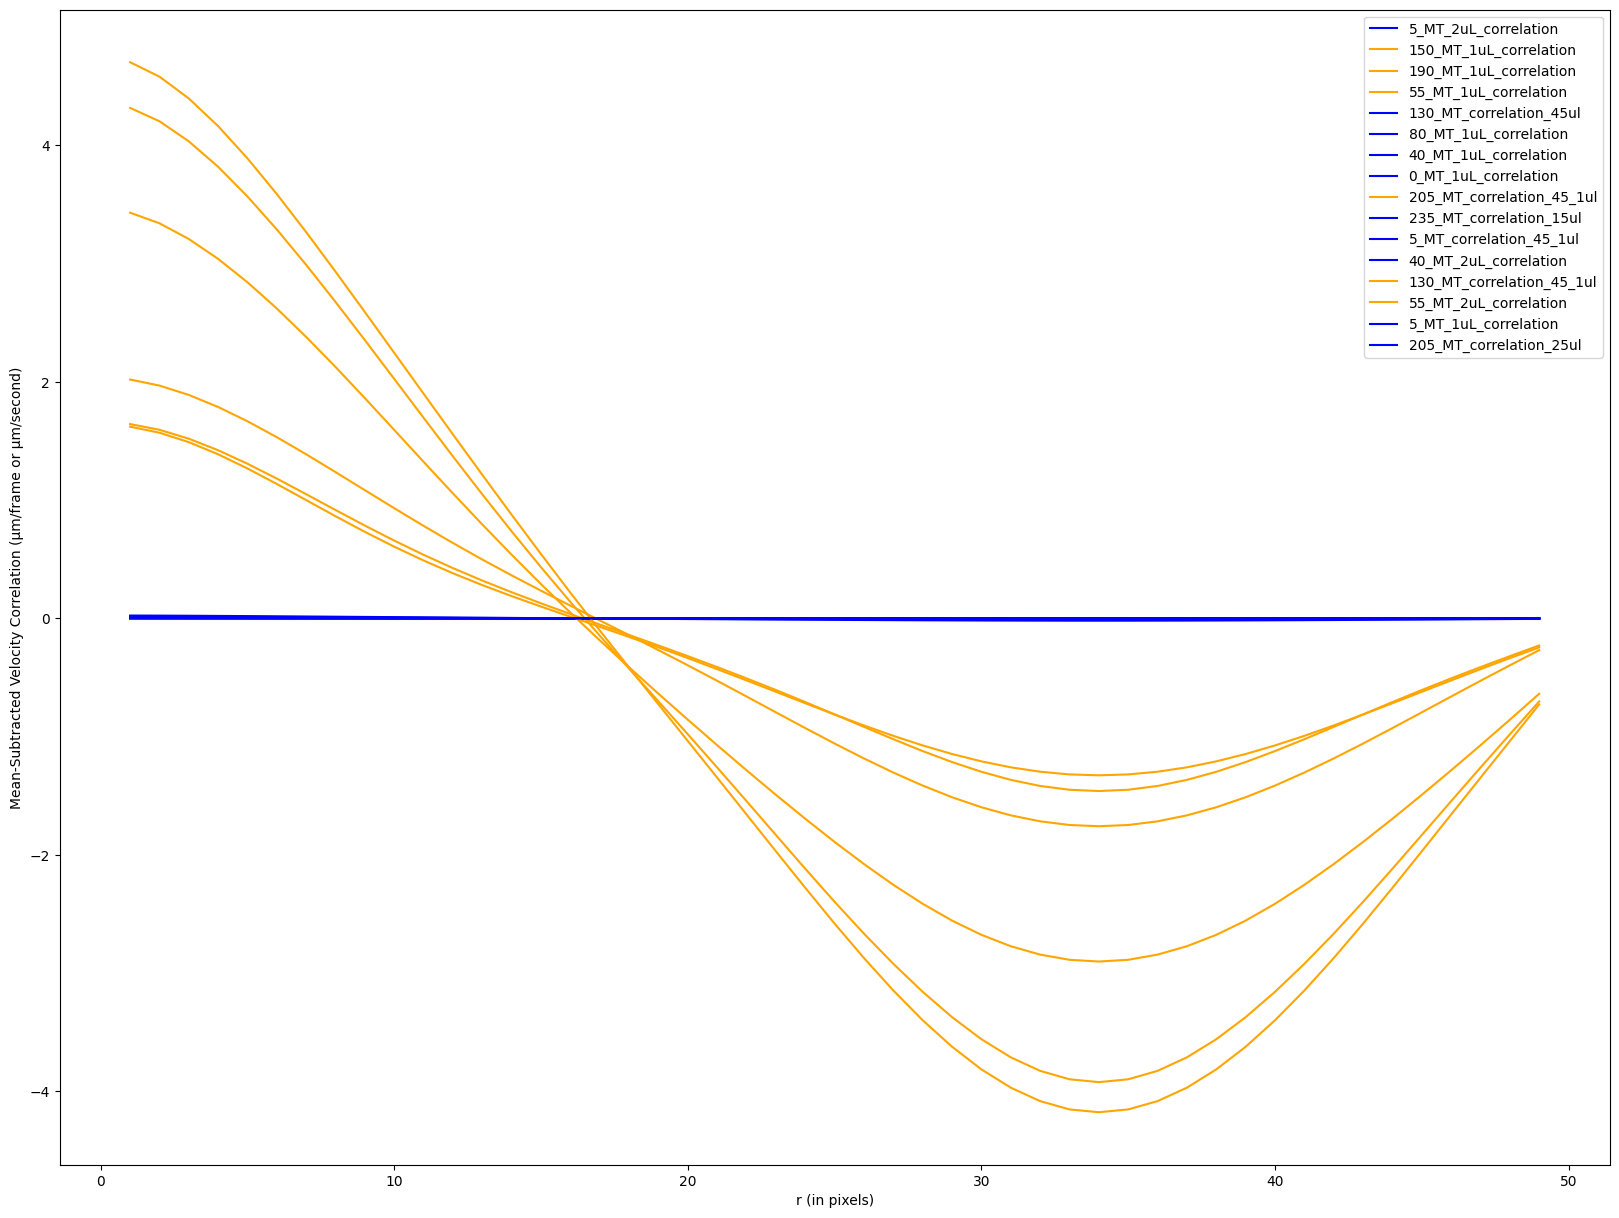

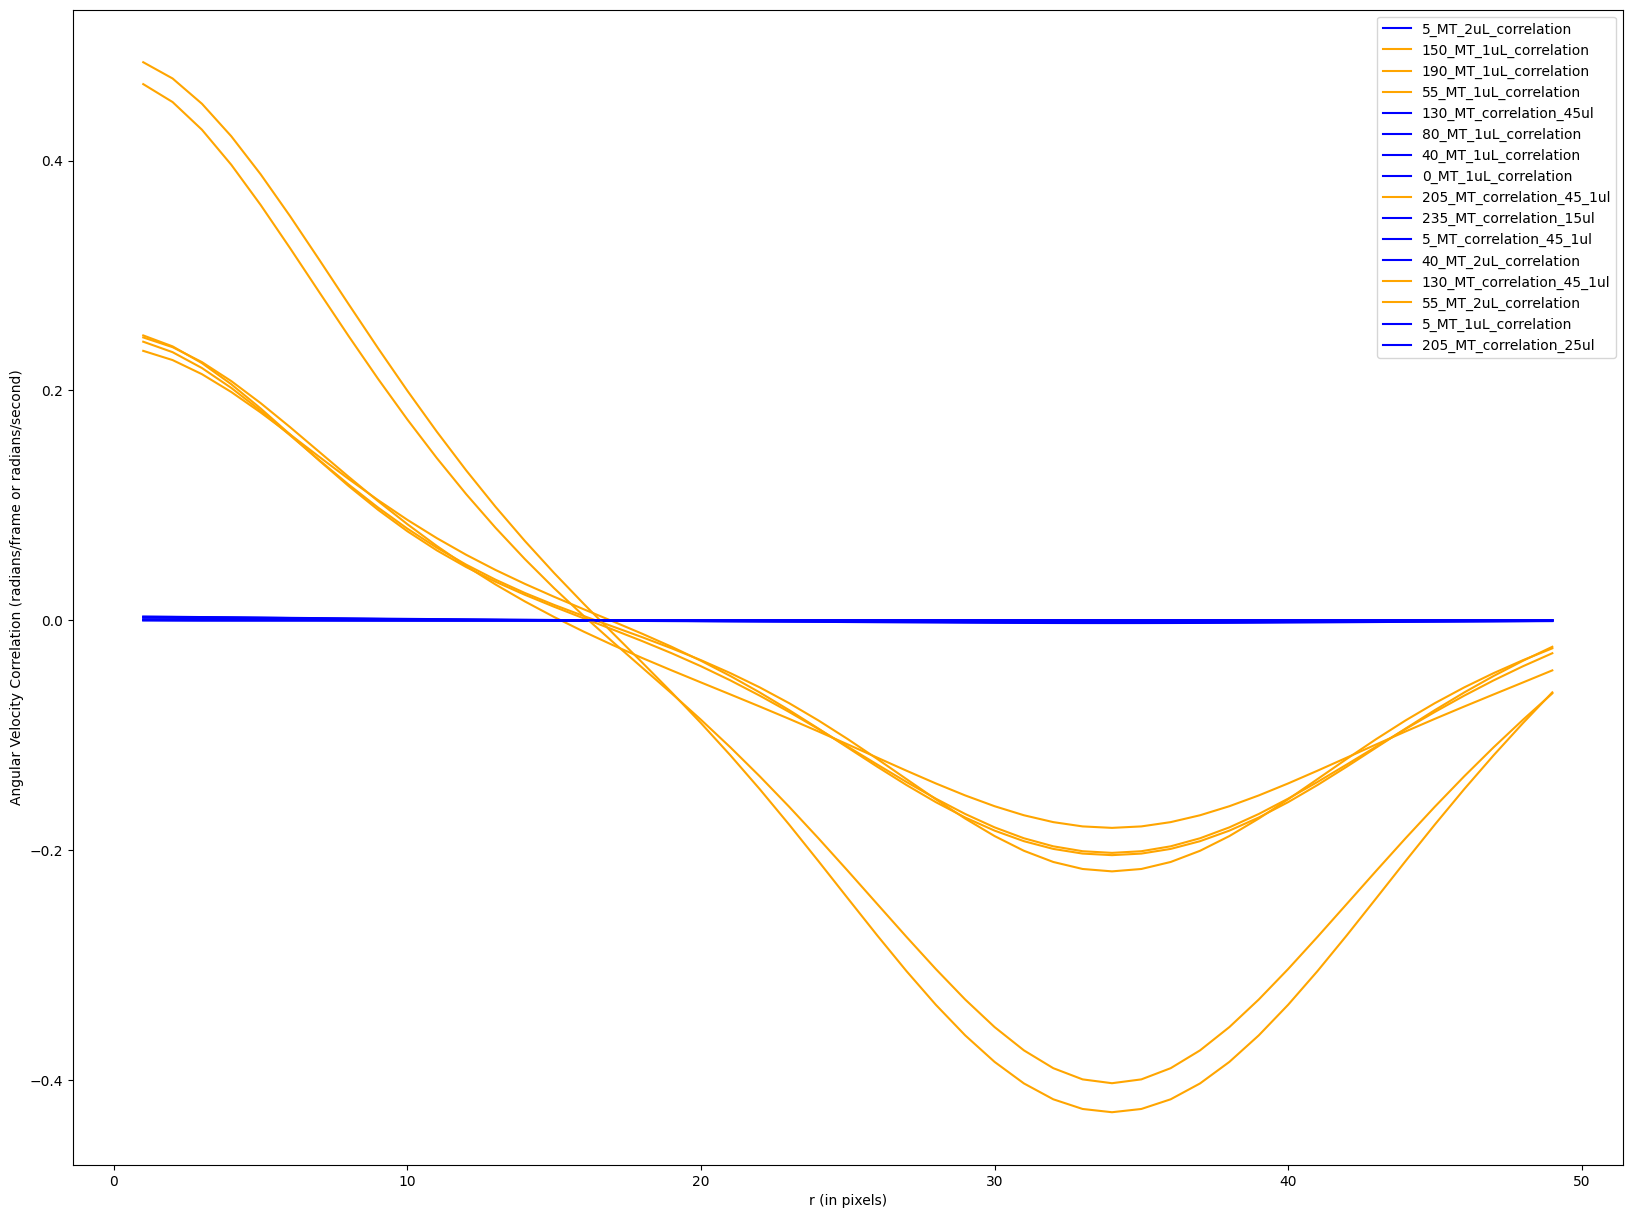

In [12]:
pixel_to_micron = 0.43  # Conversion factor: 0.43 µm/pixel

base_directory = "/home/shichenliu/Dropbox/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/correlation_good"
all_pkl_files = get_all_pkl_files(base_directory)

r_values = list(range(1, 50))

# Plotting Mean-Subtracted Velocity Correlation for all experiments
plt.figure(figsize=(20, 15))
for pkl_file in all_pkl_files:
    with open(pkl_file, 'rb') as f:
        velocity_data = pickle.load(f)
    
    avg_UX = np.mean([data[0] * pixel_to_micron for data in velocity_data.values()], axis=0)  # Conversion to µm/frame or µm/second
    avg_UY = np.mean([data[1] * pixel_to_micron for data in velocity_data.values()], axis=0)

    mean_subtracted_vals = [mean_subtracted_velocity_correlation(avg_UX, avg_UY, r) for r in r_values]
    color = 'orange' if max(mean_subtracted_vals) > 1 else 'blue'
    plt.plot(r_values, mean_subtracted_vals, color=color, label=os.path.basename(os.path.dirname(pkl_file)).replace("_new", ""))

plt.xlabel('r (in pixels)')
plt.ylabel('Mean-Subtracted Velocity Correlation (µm/frame or µm/second)')
plt.legend()
plt.show()

# Plotting Angular Velocity Correlation for all experiments
plt.figure(figsize=(20, 15))
for pkl_file in all_pkl_files:
    with open(pkl_file, 'rb') as f:
        velocity_data = pickle.load(f)
    
    avg_UX = np.mean([data[0] * pixel_to_micron for data in velocity_data.values()], axis=0)
    avg_UY = np.mean([data[1] * pixel_to_micron for data in velocity_data.values()], axis=0)
    omega = compute_vorticity(avg_UX, avg_UY)

    angular_vals = [angular_velocity_correlation(omega, r) for r in r_values]
    color = 'orange' if max(angular_vals) > 0.1 else 'blue'
    plt.plot(r_values, angular_vals, color=color, label=os.path.basename(os.path.dirname(pkl_file)).replace("_new", ""))

plt.xlabel('r (in pixels)')
plt.ylabel('Angular Velocity Correlation (radians/frame or radians/second)')
plt.legend()
plt.show()


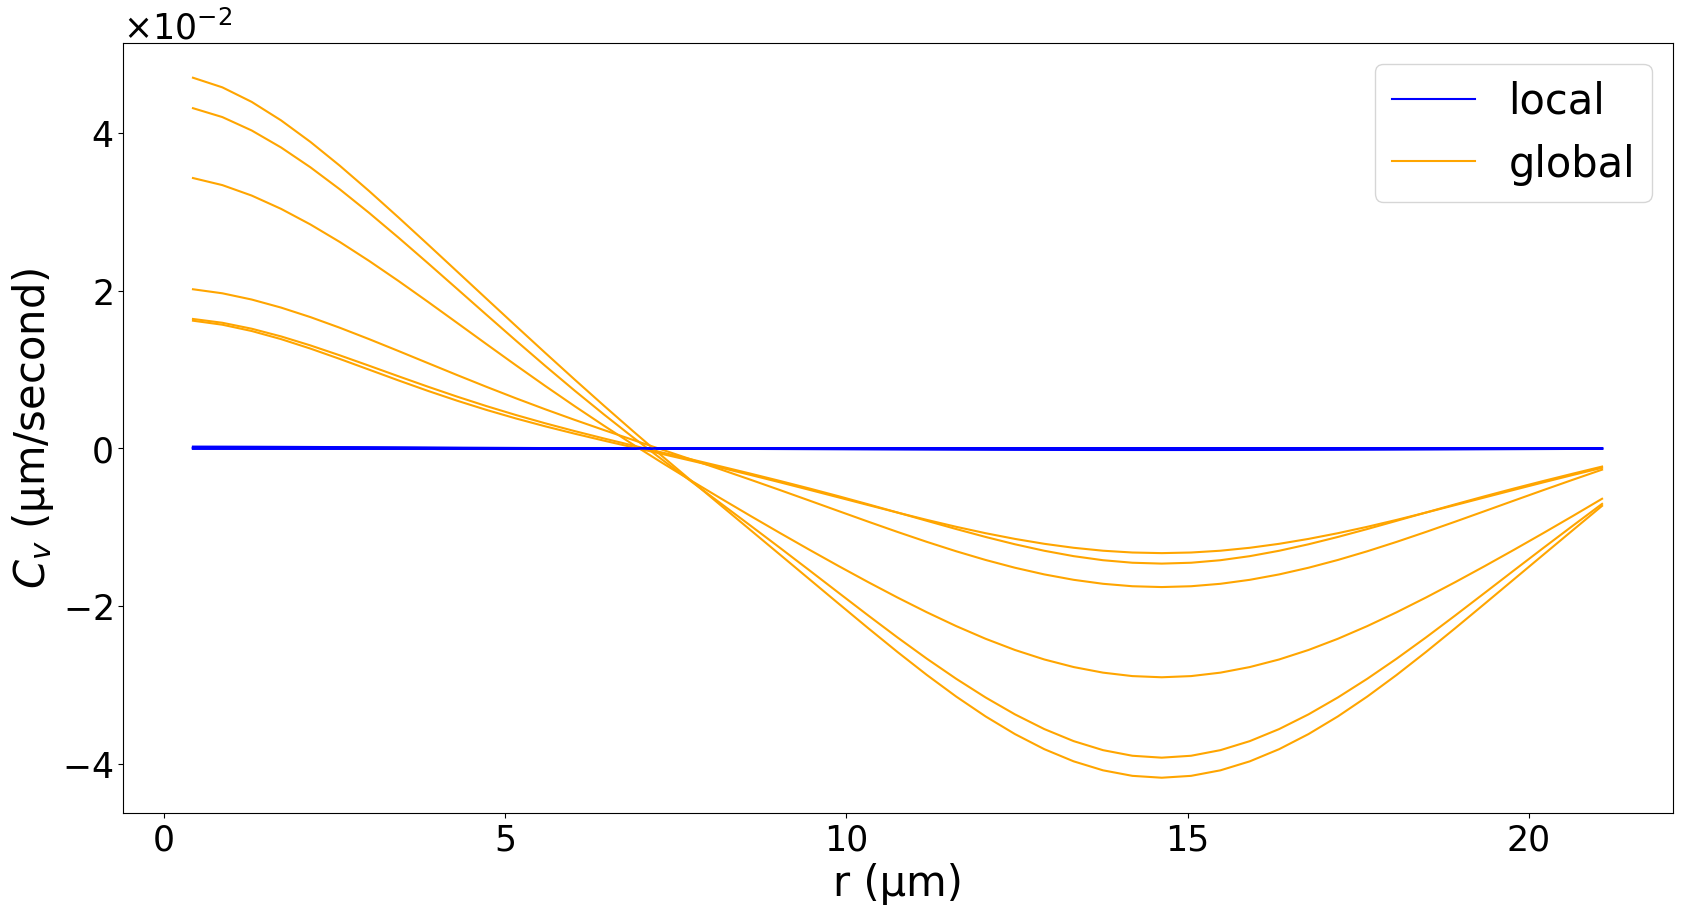

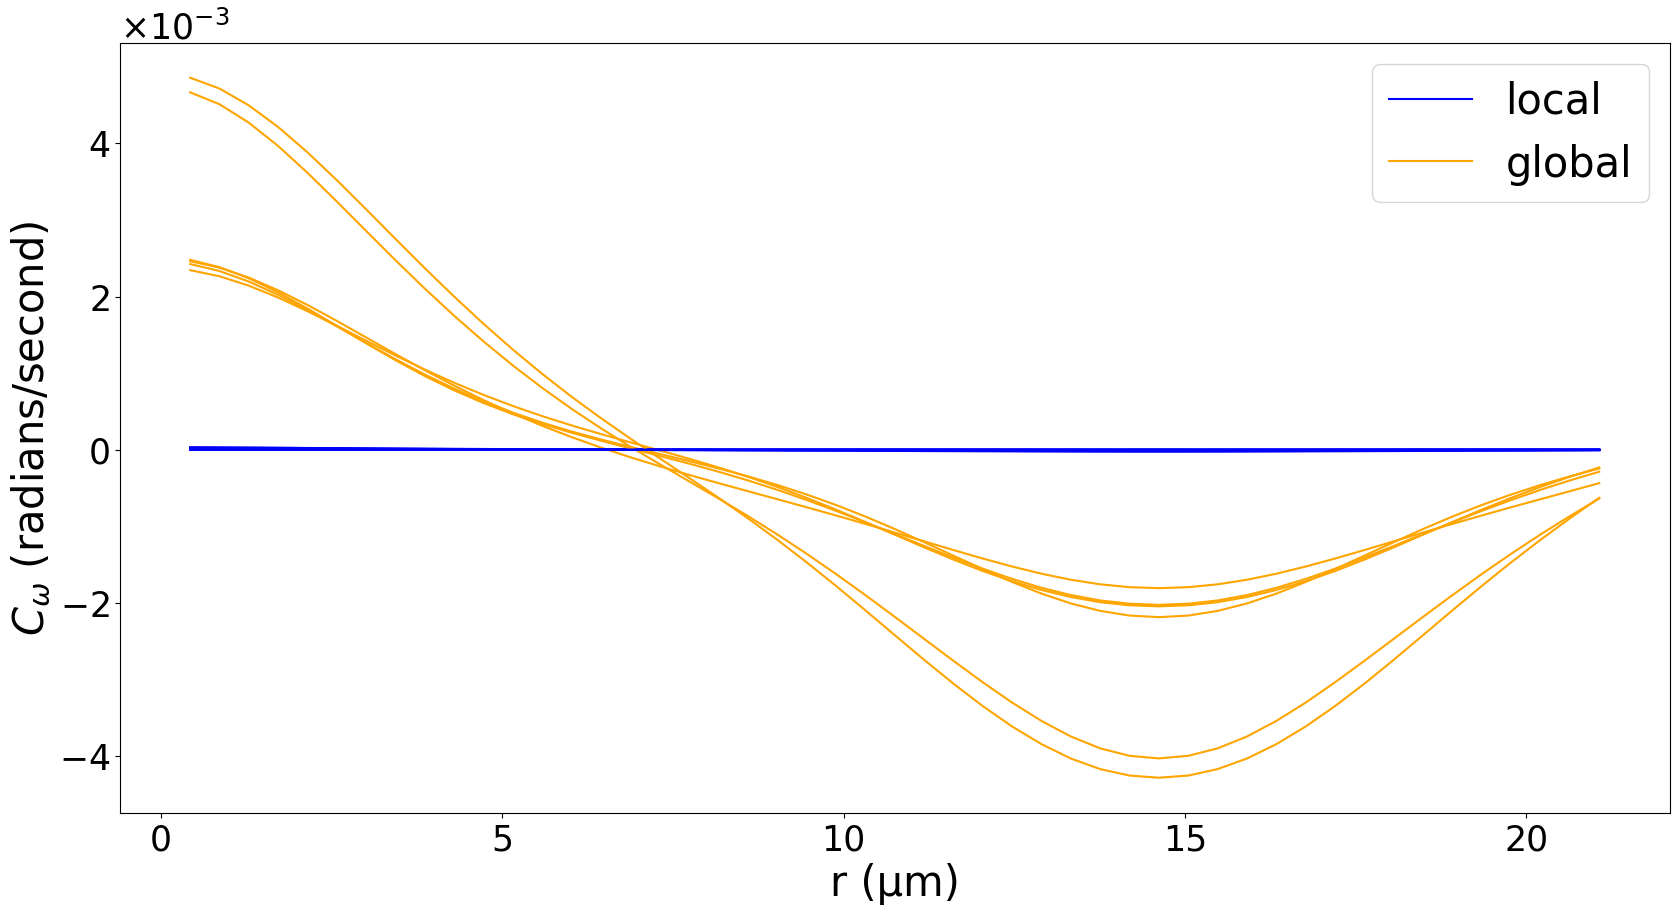

In [13]:
pixel_to_micron = 0.43
time_factor = 10
base_directory = "/home/shichenliu/Dropbox/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/correlation_good"
all_pkl_files = get_all_pkl_files(base_directory)

r_values_pixels = list(range(1, 50))
r_values_micron = [r * pixel_to_micron for r in r_values_pixels]

# Plotting Mean-Subtracted Velocity Correlation for all experiments
plt.figure(figsize=(20, 10))
added_labels = set()  # Set to keep track of added labels
for pkl_file in all_pkl_files:
    with open(pkl_file, 'rb') as f:
        velocity_data = pickle.load(f)
    
    avg_UX = np.mean([data[0] * pixel_to_micron /10 for data in velocity_data.values()], axis=0)
    avg_UY = np.mean([data[1] * pixel_to_micron /10 for data in velocity_data.values()], axis=0)

    times = [tt * time_factor for tt in sorted(velocity_data.keys())]  # Convert frame numbers to seconds
    mean_subtracted_vals = [mean_subtracted_velocity_correlation(avg_UX, avg_UY, r) for r in r_values_pixels]
    color = 'orange' if max(mean_subtracted_vals) > 0.01 else 'blue'
    label = "global" if color == "orange" else "local"
    
    if label not in added_labels:  # Add to the plot only if label is not yet added
        plt.plot(r_values_micron, mean_subtracted_vals, color=color, label=label)
        added_labels.add(label)
    else:
        plt.plot(r_values_micron, mean_subtracted_vals, color=color)

plt.xlabel('r (µm)', fontsize=30)
plt.ylabel(r'$C_v$ (µm/second)', fontsize=30)
plt.legend(fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.gca().get_yaxis().get_offset_text().set_size(25)  # Adjust the size of the exponent
plt.show()
plt.show()

# Plotting Angular Velocity Correlation for all experiments
plt.figure(figsize=(20, 10))
added_labels = set()  # Reset the set for the next plot
for pkl_file in all_pkl_files:
    with open(pkl_file, 'rb') as f:
        velocity_data = pickle.load(f)
    
    avg_UX = np.mean([data[0] * pixel_to_micron /10 for data in velocity_data.values()], axis=0)
    avg_UY = np.mean([data[1] * pixel_to_micron/10 for data in velocity_data.values()], axis=0)
    omega = compute_vorticity(avg_UX, avg_UY)

    angular_vals = [angular_velocity_correlation(omega, r) for r in r_values_pixels]
    color = 'orange' if max(angular_vals) > 0.001 else 'blue'
    label = "global" if color == "orange" else "local"
    
    if label not in added_labels:  # Add to the plot only if label is not yet added
        plt.plot(r_values_micron, angular_vals, color=color, label=label)
        added_labels.add(label)
    else:
        plt.plot(r_values_micron, angular_vals, color=color)


plt.xlabel('r (µm)', fontsize=30)
plt.ylabel(r'$C_\omega$ (radians/second)', fontsize=30)
plt.legend(fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.gca().get_yaxis().get_offset_text().set_size(25)  # Adjust the size of the exponent
plt.show()
plt.show()


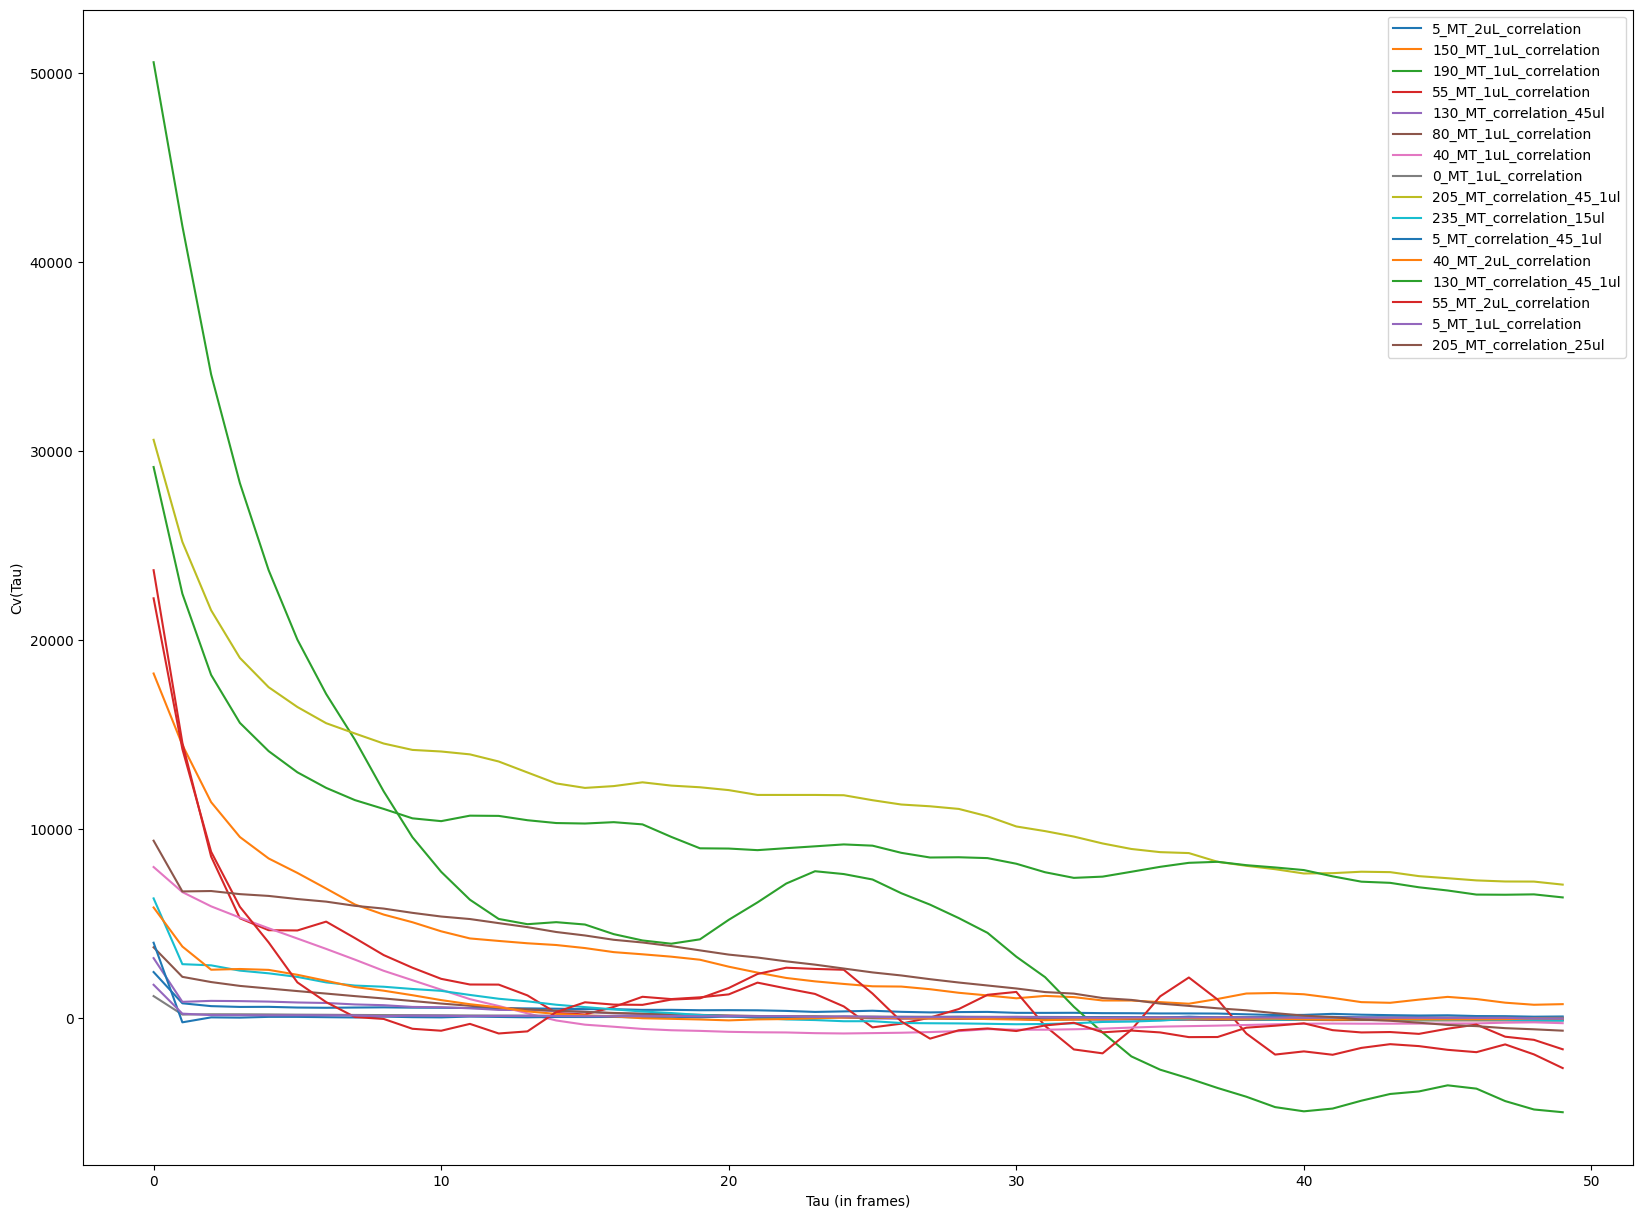

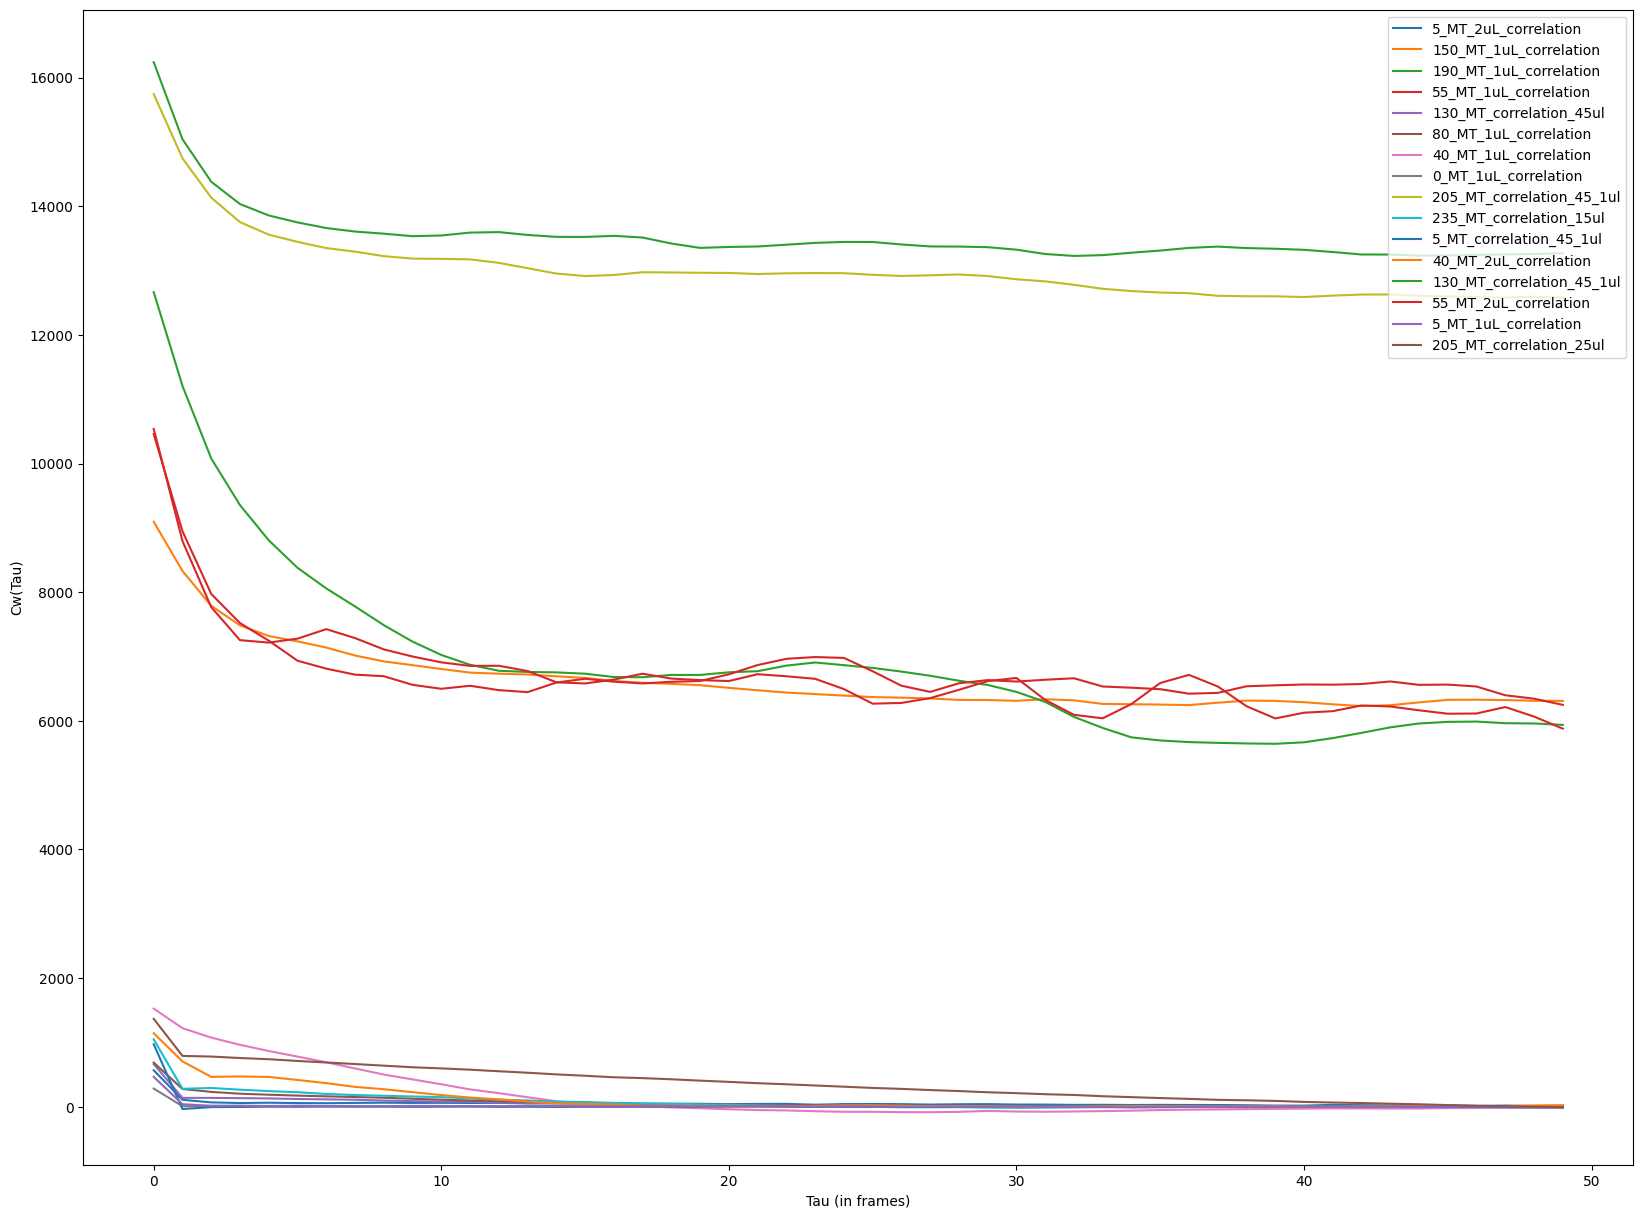

In [14]:
def temporal_velocity_correlation(velocity_data, tau):
    avg_UX = np.mean([data[0] for data in velocity_data.values()], axis=0)
    avg_UY = np.mean([data[1] for data in velocity_data.values()], axis=0)
    total_times = len(velocity_data)
    
    correlation_sum = 0
    for tt in range(total_times - tau):
        correlation_sum += np.sum((velocity_data[tt][0] - avg_UX) * (velocity_data[tt + tau][0] - avg_UX))
        correlation_sum += np.sum((velocity_data[tt][1] - avg_UY) * (velocity_data[tt + tau][1] - avg_UY))
    
    return correlation_sum / (total_times - tau)

def temporal_angular_velocity_correlation(velocity_data, tau):
    avg_UX = np.mean([data[0] for data in velocity_data.values()], axis=0)
    avg_UY = np.mean([data[1] for data in velocity_data.values()], axis=0)
    omega_avg = compute_vorticity(avg_UX, avg_UY)
    total_times = len(velocity_data)

    correlation_sum = 0
    for tt in range(total_times - tau):
        omega_t = compute_vorticity(velocity_data[tt][0], velocity_data[tt][1])
        omega_t_tau = compute_vorticity(velocity_data[tt + tau][0], velocity_data[tt + tau][1])
        correlation_sum += np.sum(omega_t * omega_t_tau)

    return correlation_sum / (total_times - tau)

tau_values = list(range(0, 50))

# Plotting Mean-Subtracted Velocity Temporal Correlation
plt.figure(figsize=(20, 15))
for pkl_file in all_pkl_files:
    with open(pkl_file, 'rb') as f:
        velocity_data = pickle.load(f)

    Cv_vals = [temporal_velocity_correlation(velocity_data, tau) for tau in tau_values]
    plt.plot(tau_values, Cv_vals, label=os.path.basename(os.path.dirname(pkl_file)).replace("_new", ""))

plt.xlabel('Tau (in frames)')
plt.ylabel('Cv(Tau)')
plt.legend()
plt.show()

# Plotting Angular Velocity Temporal Correlation
plt.figure(figsize=(20, 15))
for pkl_file in all_pkl_files:
    with open(pkl_file, 'rb') as f:
        velocity_data = pickle.load(f)

    Cw_vals = [temporal_angular_velocity_correlation(velocity_data, tau) for tau in tau_values]
    plt.plot(tau_values, Cw_vals, label=os.path.basename(os.path.dirname(pkl_file)).replace("_new", ""))

plt.xlabel('Tau (in frames)')
plt.ylabel('Cw(Tau)')
plt.legend()
plt.show()


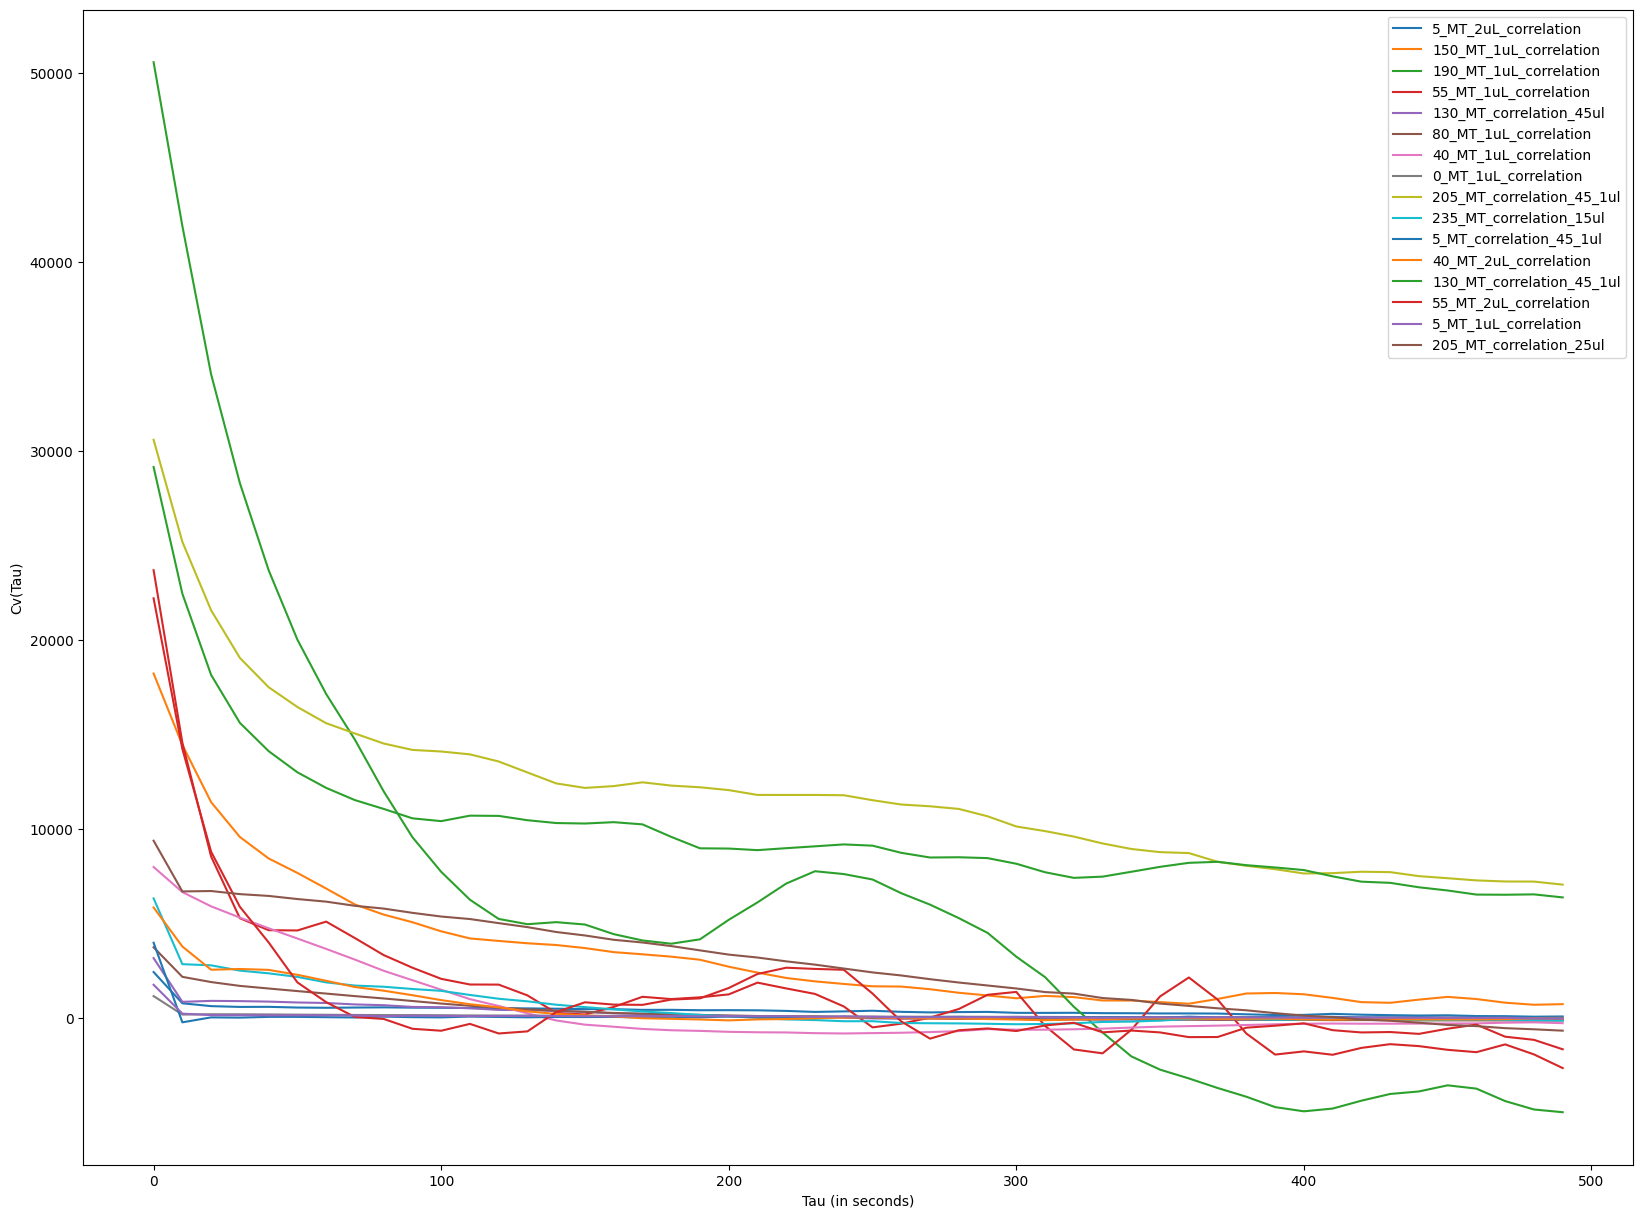

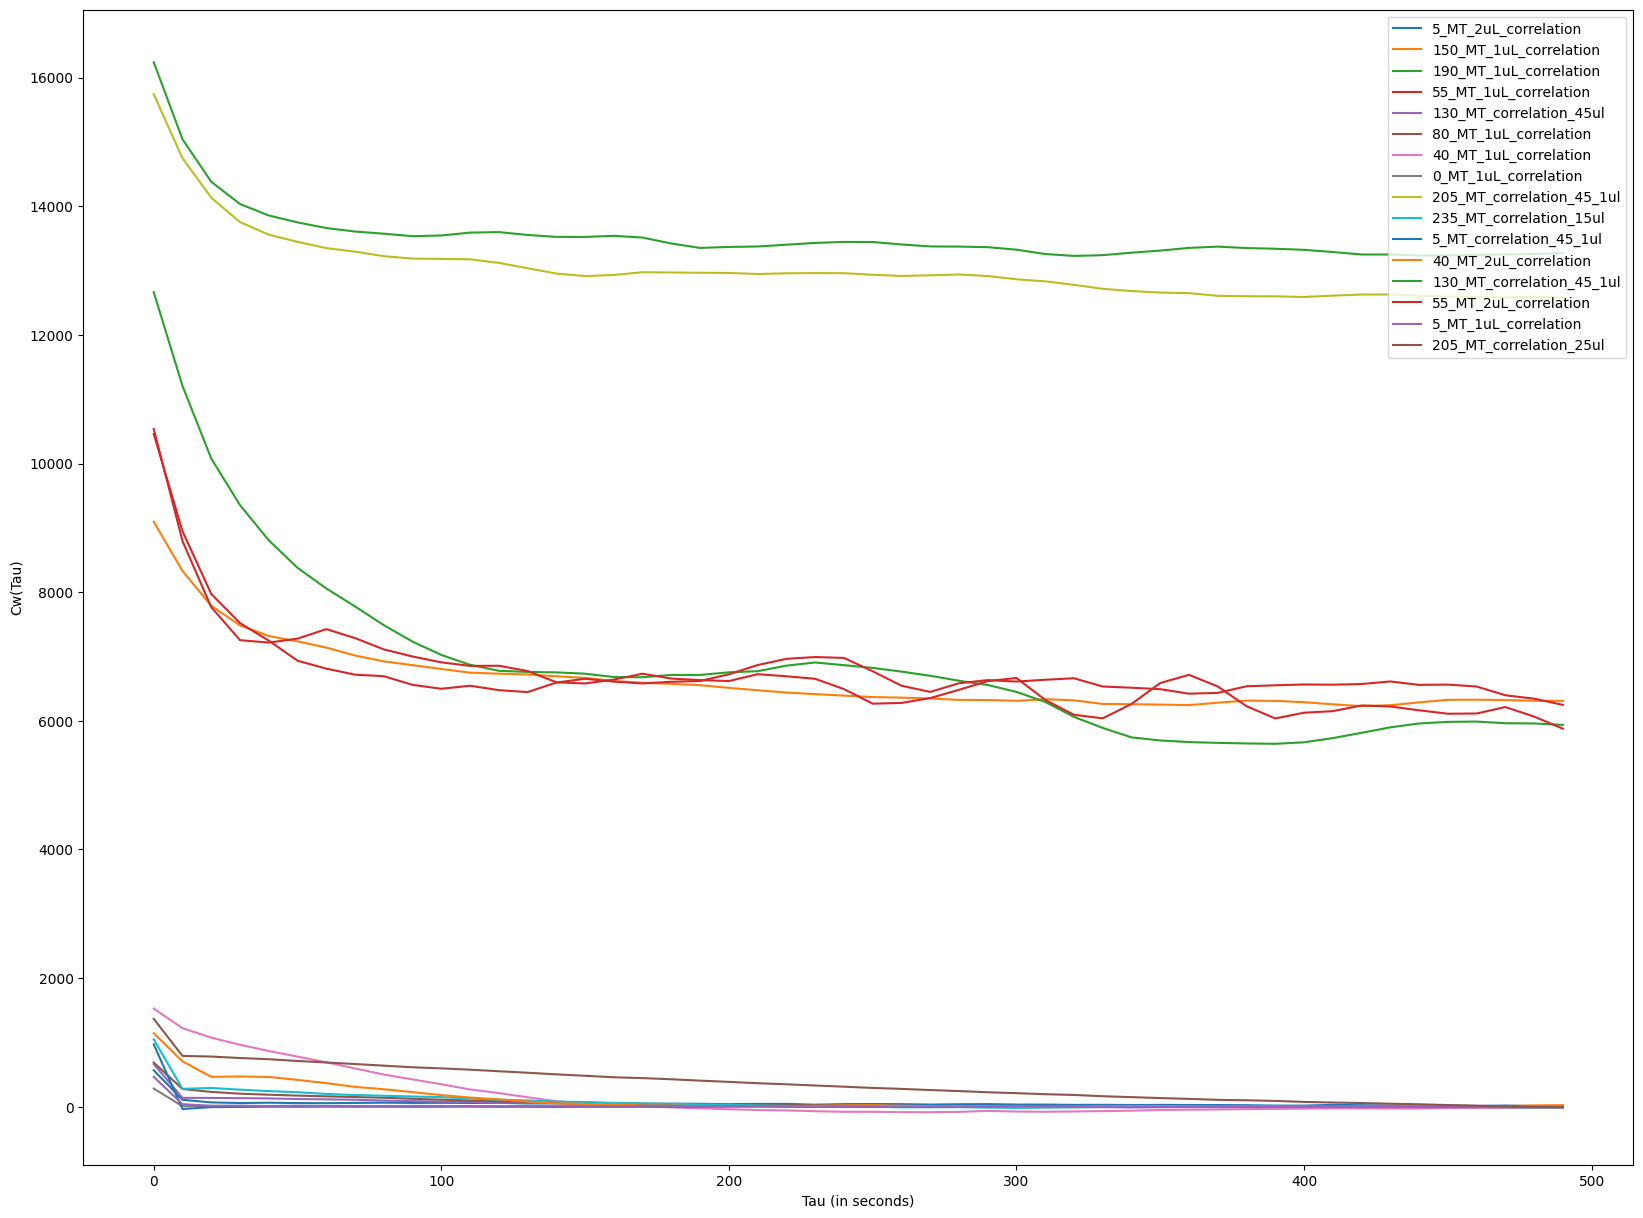

In [15]:
tau_values_frames = list(range(0, 50))
tau_values_seconds = [tau * 10 for tau in tau_values_frames]  # Convert frame counts to seconds

# Plotting Mean-Subtracted Velocity Temporal Correlation
plt.figure(figsize=(20, 15))
for pkl_file in all_pkl_files:
    with open(pkl_file, 'rb') as f:
        velocity_data = pickle.load(f)

    Cv_vals = [temporal_velocity_correlation(velocity_data, tau) for tau in tau_values_frames]
    plt.plot(tau_values_seconds, Cv_vals, label=os.path.basename(os.path.dirname(pkl_file)).replace("_new", ""))

plt.xlabel('Tau (in seconds)')
plt.ylabel('Cv(Tau)')
plt.legend()
plt.show()

# Plotting Angular Velocity Temporal Correlation
plt.figure(figsize=(20, 15))
for pkl_file in all_pkl_files:
    with open(pkl_file, 'rb') as f:
        velocity_data = pickle.load(f)

    Cw_vals = [temporal_angular_velocity_correlation(velocity_data, tau) for tau in tau_values_frames]
    plt.plot(tau_values_seconds, Cw_vals, label=os.path.basename(os.path.dirname(pkl_file)).replace("_new", ""))

plt.xlabel('Tau (in seconds)')
plt.ylabel('Cw(Tau)')
plt.legend()
plt.show()


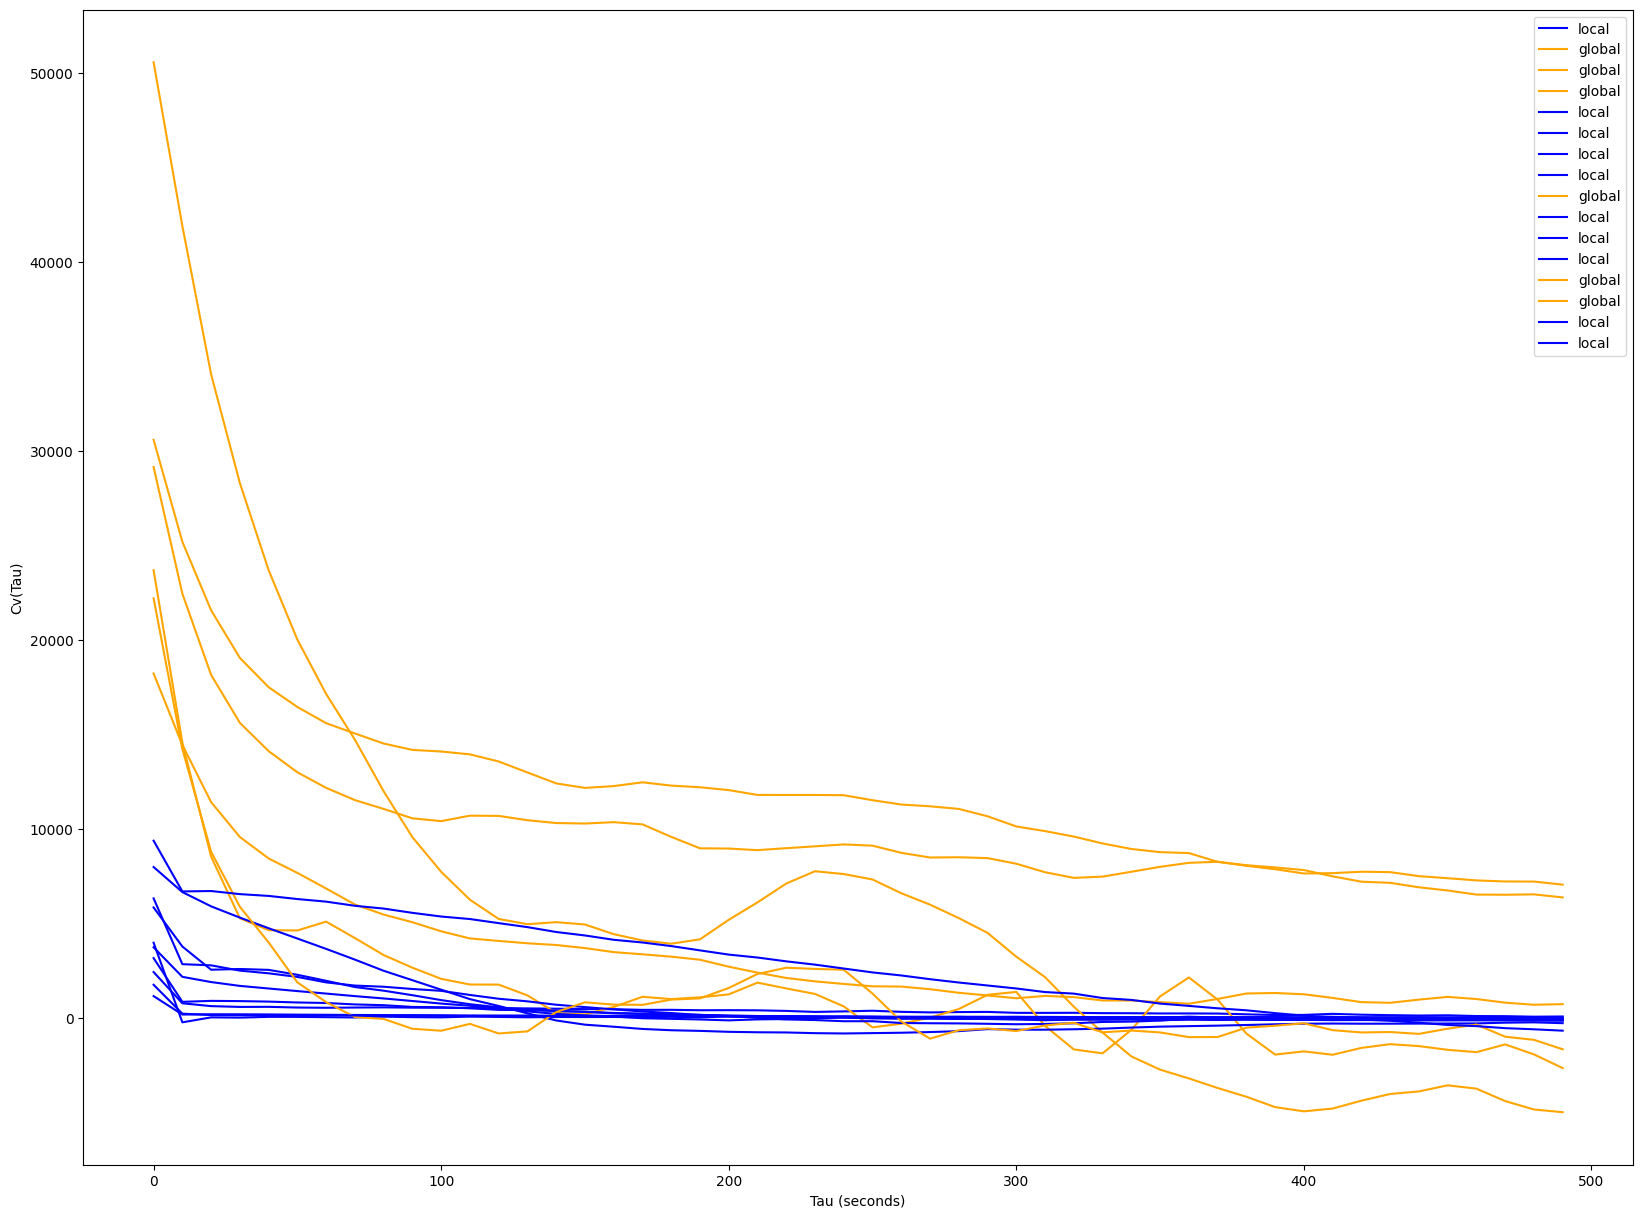

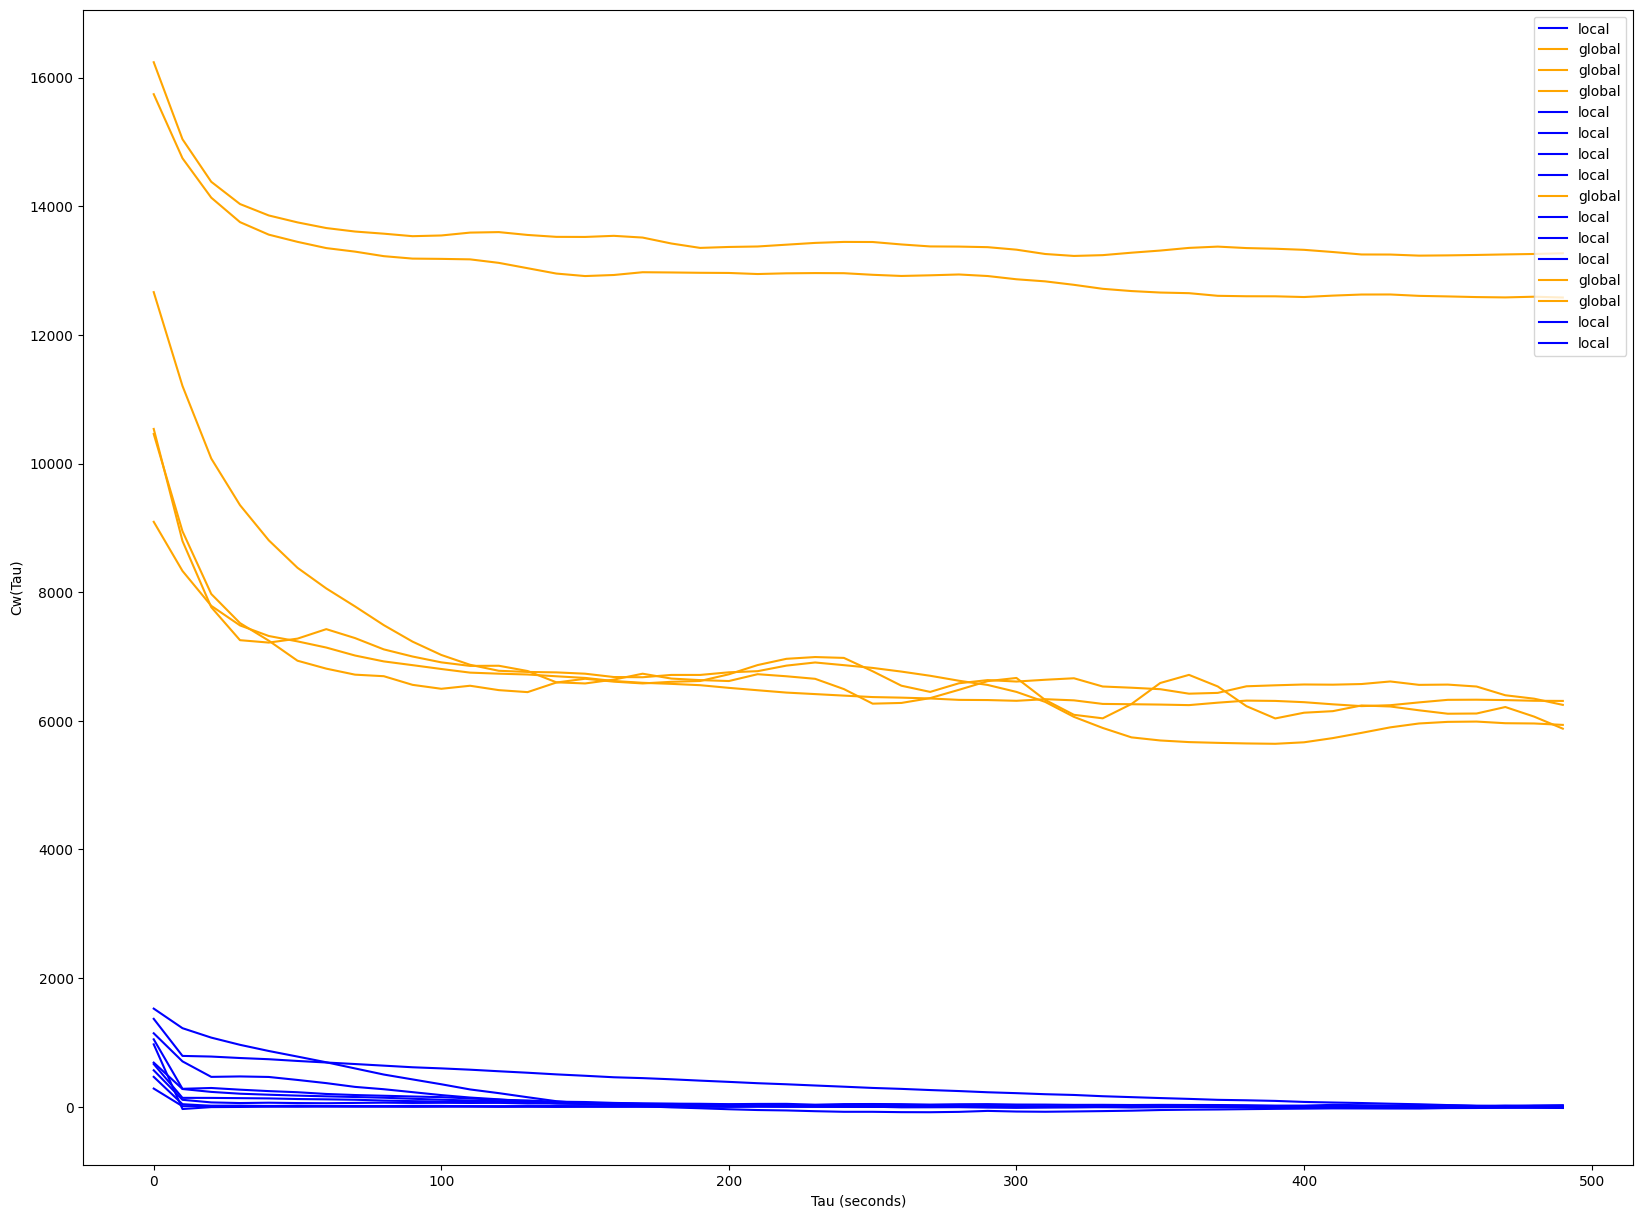

In [17]:
pixel_to_micron = 0.43
time_factor = 10  # Convert frames to seconds
base_directory = "/home/shichenliu/Dropbox/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/correlation_good"
all_pkl_files = get_all_pkl_files(base_directory)

r_values_pixels = list(range(1, 50))
r_values_micron = [r * pixel_to_micron for r in r_values_pixels]
classification = {}  # Dictionary to store the classification of experiments

# Classify based on Cv vs r
for pkl_file in all_pkl_files:
    with open(pkl_file, 'rb') as f:
        velocity_data = pickle.load(f)
    
    avg_UX = np.mean([data[0] * pixel_to_micron /10 for data in velocity_data.values()], axis=0)
    avg_UY = np.mean([data[1] * pixel_to_micron /10 for data in velocity_data.values()], axis=0)

    Cv_vals = [mean_subtracted_velocity_correlation(avg_UX, avg_UY, r) for r in r_values_pixels]
    classification[pkl_file] = "global" if max(Cv_vals) > 0.01 else "local"

tau_values_frames = list(range(0, 50))
tau_values_seconds = [tau * time_factor for tau in tau_values_frames]  # Convert frame counts to seconds

# Plotting Cv vs tau
plt.figure(figsize=(20, 15))
for pkl_file in all_pkl_files:
    with open(pkl_file, 'rb') as f:
        velocity_data = pickle.load(f)

    Cv_vals = [temporal_velocity_correlation(velocity_data, tau) for tau in tau_values_frames]
    color = 'orange' if classification[pkl_file] == "global" else 'blue'
    plt.plot(tau_values_seconds, Cv_vals, color=color, label=classification[pkl_file])

plt.xlabel('Tau (seconds)')
plt.ylabel('Cv(Tau)')
plt.legend()
plt.show()

# Plotting Cw vs tau
plt.figure(figsize=(20, 15))
for pkl_file in all_pkl_files:
    with open(pkl_file, 'rb') as f:
        velocity_data = pickle.load(f)

    Cw_vals = [temporal_angular_velocity_correlation(velocity_data, tau) for tau in tau_values_frames]
    color = 'orange' if classification[pkl_file] == "global" else 'blue'
    plt.plot(tau_values_seconds, Cw_vals, color=color, label=classification[pkl_file])

plt.xlabel('Tau (seconds)')
plt.ylabel('Cw(Tau)')
plt.legend()
plt.show()


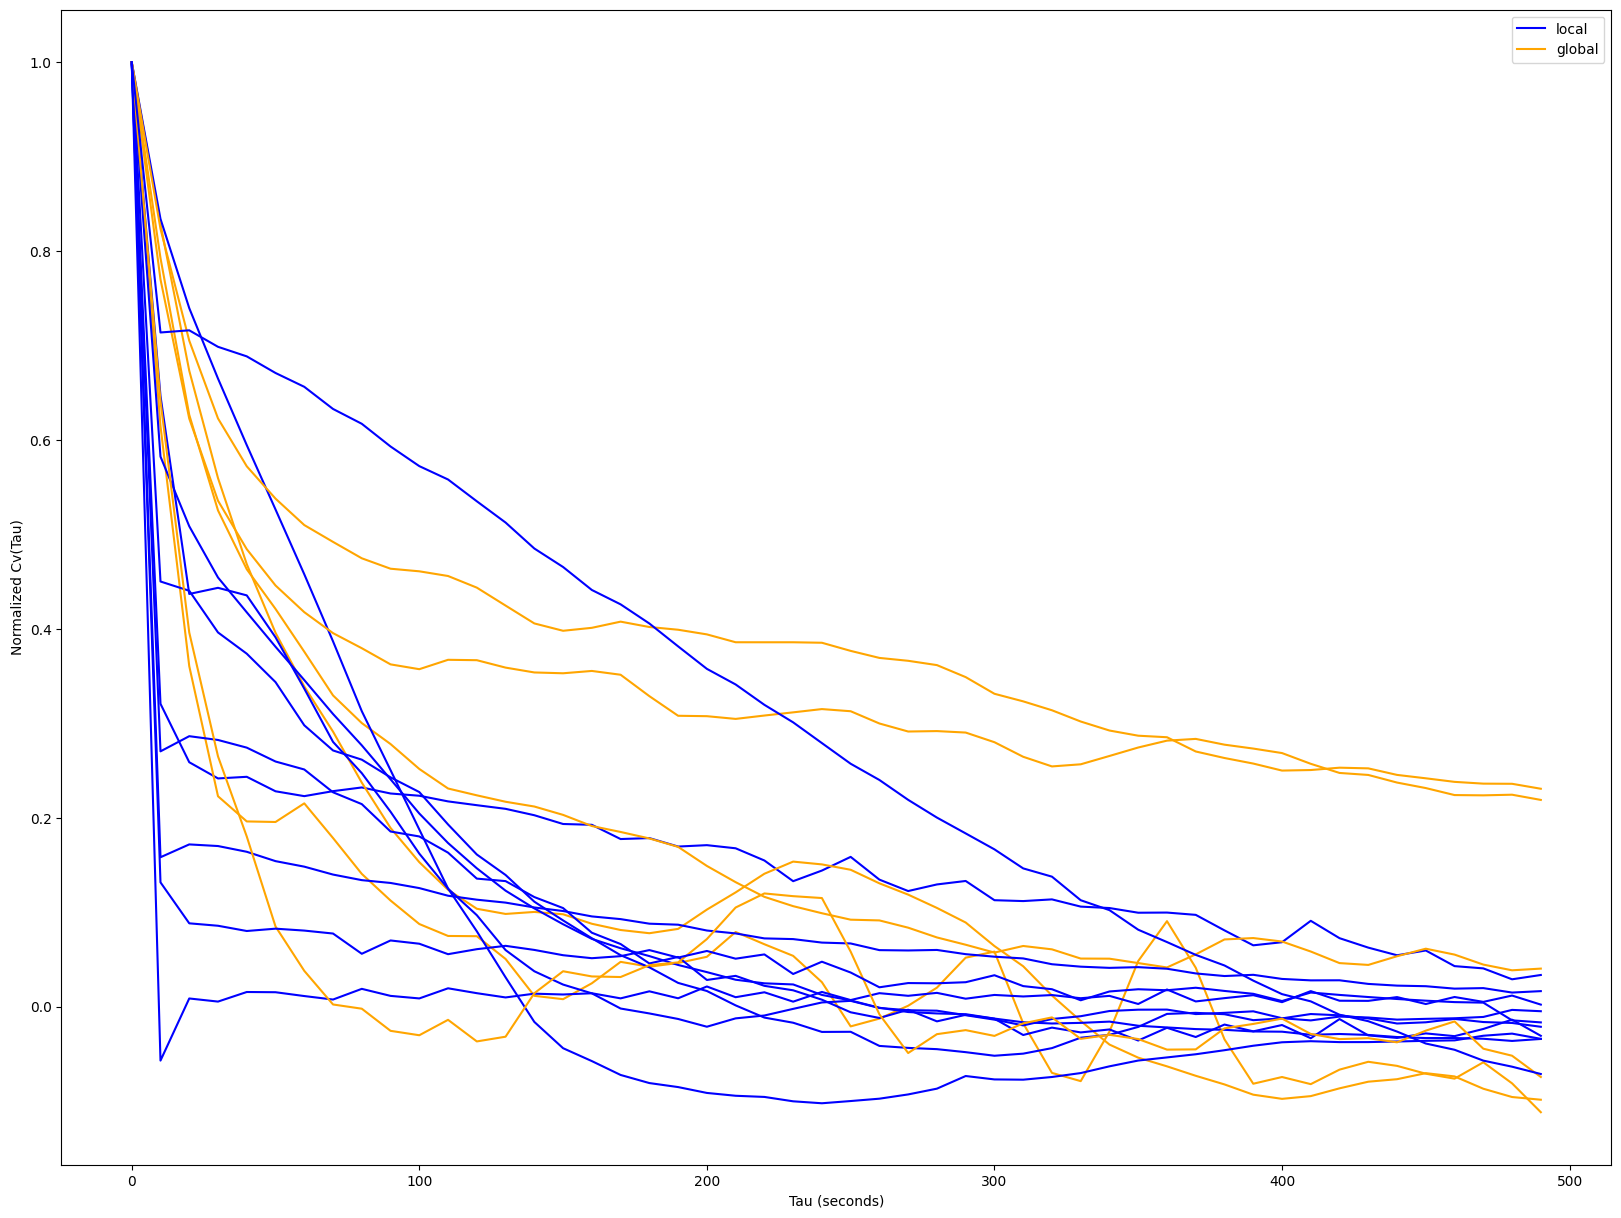

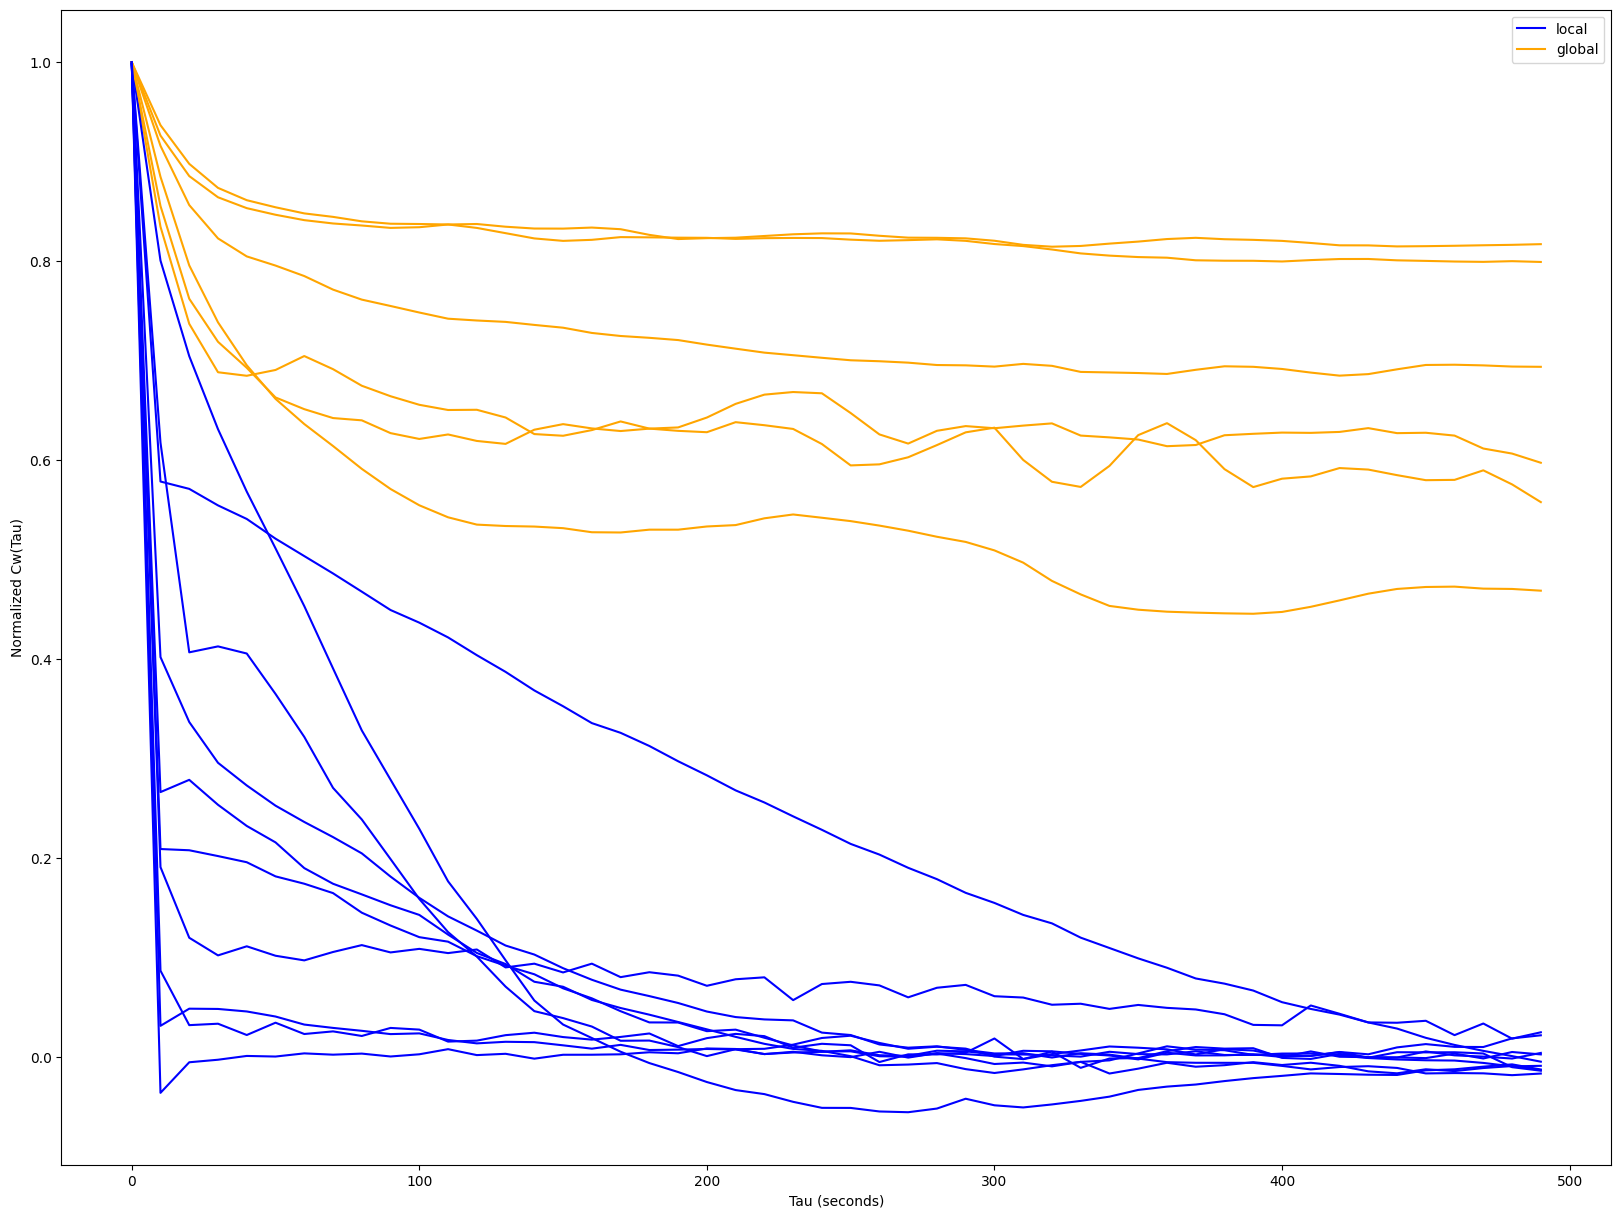

In [19]:
# ...

# Plotting Cv vs tau
plt.figure(figsize=(20, 15))
added_labels = set()  # Set to keep track of added labels
for pkl_file in all_pkl_files:
    with open(pkl_file, 'rb') as f:
        velocity_data = pickle.load(f)

    Cv_vals = [temporal_velocity_correlation(velocity_data, tau) for tau in tau_values_frames]
    Cv_0 = Cv_vals[0]
    Cv_vals_normalized = [cv/Cv_0 for cv in Cv_vals]
    
    color = 'orange' if classification[pkl_file] == "global" else 'blue'
    label = classification[pkl_file]
    
    if label not in added_labels:  # Add to the plot only if label is not yet added
        plt.plot(tau_values_seconds, Cv_vals_normalized, color=color, label=label)
        added_labels.add(label)
    else:
        plt.plot(tau_values_seconds, Cv_vals_normalized, color=color)

plt.xlabel('Tau (seconds)')
plt.ylabel('Normalized Cv(Tau)')
plt.legend()
plt.show()

# Plotting Cw vs tau
plt.figure(figsize=(20, 15))
added_labels = set()  # Reset the set for the next plot
for pkl_file in all_pkl_files:
    with open(pkl_file, 'rb') as f:
        velocity_data = pickle.load(f)

    Cw_vals = [temporal_angular_velocity_correlation(velocity_data, tau) for tau in tau_values_frames]
    Cw_0 = Cw_vals[0]
    Cw_vals_normalized = [cw/Cw_0 for cw in Cw_vals]
    
    color = 'orange' if classification[pkl_file] == "global" else 'blue'
    label = classification[pkl_file]
    
    if label not in added_labels:  # Add to the plot only if label is not yet added
        plt.plot(tau_values_seconds, Cw_vals_normalized, color=color, label=label)
        added_labels.add(label)
    else:
        plt.plot(tau_values_seconds, Cw_vals_normalized, color=color)

plt.xlabel('Tau (seconds)')
plt.ylabel('Normalized Cw(Tau)')
plt.legend()
plt.show()


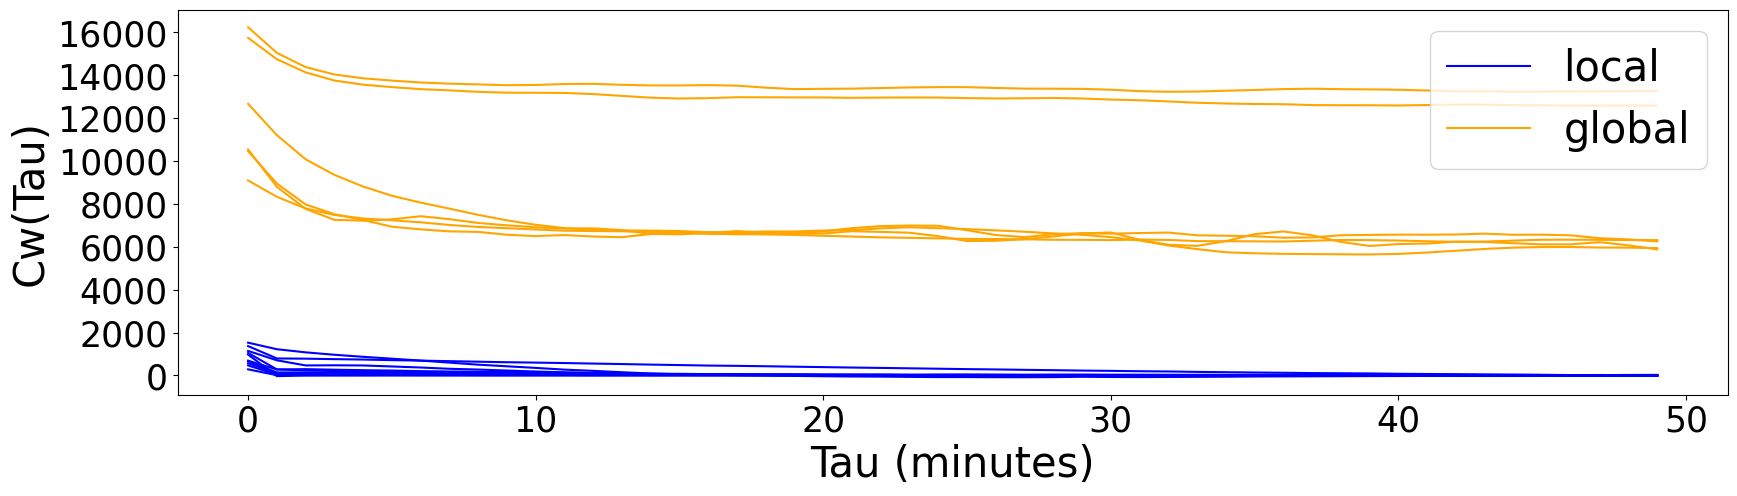

In [20]:
pixel_to_micron = 0.43
time_factor = 1 # Convert frames to minutes (10 seconds per frame, and 60 seconds in a minute)
base_directory = "/home/shichenliu/Dropbox/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/correlation_good"
all_pkl_files = get_all_pkl_files(base_directory)

r_values_pixels = list(range(1, 50))
r_values_micron = [r * pixel_to_micron for r in r_values_pixels]
classification = {}

# Classify based on Cv vs r
for pkl_file in all_pkl_files:
    with open(pkl_file, 'rb') as f:
        velocity_data = pickle.load(f)
    
    avg_UX = np.mean([data[0] * pixel_to_micron /10 for data in velocity_data.values()], axis=0)
    avg_UY = np.mean([data[1] * pixel_to_micron /10 for data in velocity_data.values()], axis=0)

    Cv_vals = [mean_subtracted_velocity_correlation(avg_UX, avg_UY, r) for r in r_values_pixels]
    classification[pkl_file] = "global" if max(Cv_vals) > 0.01 else "local"

tau_values_frames = list(range(0, 50))
tau_values_minutes = [tau * time_factor for tau in tau_values_frames]  # Convert frame counts to minutes


# Plotting Cw vs tau
plt.figure(figsize=(20, 5))
added_labels = set()  # Reset the set for the next plot
for pkl_file in all_pkl_files:
    with open(pkl_file, 'rb') as f:
        velocity_data = pickle.load(f)

    Cw_vals = [temporal_angular_velocity_correlation(velocity_data, tau) for tau in tau_values_frames]
    color = 'orange' if classification[pkl_file] == "global" else 'blue'
    label = classification[pkl_file]
    
    if label not in added_labels:  # Add to the plot only if label is not yet added
        plt.plot(tau_values_minutes, Cw_vals, color=color, label=label)
        added_labels.add(label)
    else:
        plt.plot(tau_values_minutes, Cw_vals, color=color)

plt.xlabel('Tau (minutes)', fontsize=30)
plt.ylabel('Cw(Tau)', fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=30)

plt.show()
